In [6]:
import numpy as np
from skimage import io
from pathlib import Path
import re
import ants
from skimage.transform import resize
from tqdm import tqdm
from skimage.morphology import skeletonize_3d, binary_closing
from scipy.ndimage import distance_transform_edt, binary_dilation
import tifffile as tif
from scipy.ndimage import binary_fill_holes
import cc3d
from scipy.io import loadmat, savemat
import sknw
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy as sp
import vg
from pytransform3d.rotations import matrix_from_axis_angle
import multiprocessing
from scipy.ndimage import convolve as conv
from scipy.stats import multivariate_normal
from skimage import color, data, restoration
from RedLionfishDeconv import doRLDeconvolutionFromNpArrays
from matplotlib.patches import Circle
from skimage.feature import peak_local_max
from statistics import mode
import imageio
from PIL import Image
from PIL.TiffTags import TAGS
from tifffile import TiffFile
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
plt.rcParams['figure.figsize'] = [15, 15]

In [7]:
np.std([24,27,35,33,37,22,21,23,26,30,22,40,22,24,28])

5.885575587824864

In [8]:
def _ants_affine_to_distance(affine):

    dx, dy, dz = affine[9:]

    rot_x = np.arcsin(affine[6])
    cos_rot_x = np.cos(rot_x)
    rot_y = np.arctan2(affine[7] / cos_rot_x, affine[8] / cos_rot_x)
    rot_z = np.arctan2(affine[3] / cos_rot_x, affine[0] / cos_rot_x)

    deg = np.degrees

    return dx, dy, dz, deg(rot_x), deg(rot_y), deg(rot_z)

In [9]:
print('start')

start


In [10]:
mouse_ids_path = Path('matt_raw_warped')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*res*.tif'))#grab folder names/mouse ids
mouse_ids = sorted([x.as_posix() for x in mouse_ids])
data_dicts = [
    {"image":image_name}
    for image_name in mouse_ids
]

#data_dicts = [data_dicts[_i]]
re.sub('matt_raw_warped_upsampled','matt_preds_registered',data_dicts[0]["image"])

'matt_raw_warped/06162021_45-XYZres288_0001_warped.tif'

# Define connected componnet removal

In [11]:
def remove_small_comps_3d(image, thresh = 500):
    """

    Parameters
    ----------
    image : binary np array with uint8 elements
        3d numpy matrix, connected components will be removed form this image
    thresh : int64
        smallest connected components to keep

    Returns
    -------
    np.array with uint8 elements, binary
        binary image with connected components below the threshold removed.

    """
    img_lab, N = cc3d.connected_components(image,return_N=True)
    unique, counts = np.unique(img_lab, return_counts=True)
    unique_keep = unique[counts>thresh]
    unique_keep = np.delete(unique_keep,[0])
    img_filt = np.zeros(img_lab.shape).astype('int8')
    img_filt[np.isin(img_lab,unique_keep)] = 1
    return img_filt.astype('uint8')   

def fill_holes(img,thresh=1000):
    #res = np.zeros(img.shape)
    for i in np.unique(img)[::-1]:
        _tmp = (img==i)*1.0
        _tmp = _tmp.astype('int8')
        _tmp = remove_small_comps_3d(_tmp,thresh=thresh)
        img[_tmp==1] = i
    res = img.astype('int8')
    return res

def _rotmat(vector, points):
    """
    Rotates a 3xn array of 3D coordinates from the +z normal to an
    arbitrary new normal vector.
    """
    
    vector = vg.normalize(vector)
    axis = vg.perpendicular(vg.basis.z, vector)
    angle = vg.angle(vg.basis.z, vector, units='rad')
    
    a = np.hstack((axis, (angle,)))
    R = matrix_from_axis_angle(a)
    
    r = sp.spatial.transform.Rotation.from_matrix(R)
    rotmat = r.apply(points)
    
    return rotmat

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    if np.min(dist_2)>10:
        return node
    else:
        return nodes[np.argmin(dist_2)]

# register raw iamges

In [12]:
exclude = ['XYZres103',
           'XYZres104',
           'XYZres105',
           'XYZres105',
           'XYZres107',
           'XYZres133',
           'XYZres134',
           'XYZres135',
           'XYZres136',
           'XYZres137',
           'XYZres138',
           'XYZres139',
           'XYZres140',
           'XYZres183',
           'XYZres196',
           'XYZres197',
           'XYZres260',
           'XYZres288',
           'XYZres343',
           'XYZres340',
           'XYZres341',
           'XYZres250',
           'XYZres297',
           'XYZres295',
           'XYZres457',
           'XYZres455']

In [13]:
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
    #print(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)


In [14]:
dic = {}
for key in df.keys():
    if '3D' in key and ('vbm01' not in key and 'vbm02' not in key and 'SHAM7_3D' not in key and 'TBI45_3D' not in key and 'TBI11_3D' not in key and 'TBI65_3D' not in key and 'TBI22_3D' not in key and 'TBI28_3D' not in key and 'TBI40_3D' not in key and 'TBI51_3D' not in key and 'TBI70_3D' not in key):
        if 'vbm' not in key:
            addition = re.sub('C57','',re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',key))))
        else:
            addition = ''
        df[key] = df[key][~df[key][df[key].columns[1]].isin(exclude)]
        scans = np.array(df[key][df[key].columns[1]])
        scans = [x for x in scans if 'res' in str(x)]
        bottoms_1 = df[key][df[key][df[key].columns[3]] == 500]
        bottoms_2 = df[key][df[key][df[key].columns[2]] == 500]
        bottoms = pd.concat((bottoms_1,bottoms_2))
        bottoms = np.array(bottoms[bottoms.columns[1]])
        bottoms = [addition + '/' + x for x in bottoms]
        bottoms = [x for x in bottoms if 'res' in x]
        tops_1 = df[key][df[key][df[key].columns[3]] == 0]
        tops_2 = df[key][df[key][df[key].columns[2]] == 0]
        tops = pd.concat((tops_1,tops_2))
        tops = np.array(tops[tops.columns[1]])
        tops = [addition + '/' + x for x in tops]
        tops = [x for x in tops if 'res' in x]
        if len(tops) > 1:
            dic[tops[0]] = list(tops[1:])
        elif len(tops) == 1:
            dic[tops[0]] = tops
        if len(bottoms) > 1:
            dic[bottoms[0]] = list(bottoms[1:])
        elif len(bottoms) == 1:
            dic[bottoms[0]] = bottoms

In [15]:
#dic

In [16]:
dic_2 = {'45/XYZres290':['45/XYZres296'],
         '45/XYZres297':['45/XYZres295'],
         '45/XYZres294':['45/XYZres298'],
         '45/XYZres288':['45/XYZres300'],
         '11/XYZres95':['11/XYZres98','11/XYZres102'],
         '11/XYZres92':[],
         '11/XYZres93':['11/XYZres93','11/XYZres96','11/XYZres97','11/XYZres100','11/XYZres101'],
         '11/XYZres91':['11/XYZres94','11/XYZres99'],
         '22/XYZres164':['22/XYZres165','22/XYZres168','22/XYZres169'],
         '22/XYZres160':['22/XYZres161'],
         '22/XYZres163':['22/XYZres166','22/XYZres167','22/XYZres170'],
         '22/XYZres159':['22/XYZres162'],
         '28/XYZres184':['28/XYZres185'],
         '28/XYZres188':['28/XYZres189','28/XYZres193','28/XYZres194'],
         '28/XYZres186':['28/XYZres187','28/XYZres188','28/XYZres190','28/XYZres191','28/XYZres192','28/XYZres195'],
         '28/XYZres183':[],
         '40/XYZres248':['40/XYZres249'],
         '40/XYZres245':['40/XYZres252'],
         '40/XYZres244':[],
         '40/XYZres243':['40/XYZres246','40/XYZres247','40/XYZres251'],
         '51/XYZres297':['51/XYZres298','51/XYZres302','51/XYZres305','51/XYZres301'],
         '51/XYZres296':['51/XYZres306'],
         '51/XYZres299':['51/XYZres300','51/XYZres303','51/XYZres304'],
         '65/XYZres397':['65/XYZres398','65/XYZres401','65/XYZres402','65/XYZres405','65/XYZres408','65/XYZres409'],
         '65/XYZres396':['65/XYZres399','65/XYZres400'],
         '65/XYZres403':[],
         '70/XYZres420':['70/XYZres421','70/XYZres422'],
         '70/XYZres419':['70/XYZres416','70/XYZres413','70/XYZres410','70/XYZres412','70/XYZres416'],
         '70/XYZres414':['70/XYZres417'],
         '70/XYZres411':['70/XYZres418','70/XYZres415'],
         'XYZres007':[]
        }
dic.update(dic_2) 

In [17]:
len(dic)

119

In [18]:
mouse_ids_path = Path('/home/rozakmat/projects/rrg-bojana/data/THY1-TBI')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*?[0-9]/*res*?[0-9].tif'))#grab folder names/mouse ids
images = sorted([x.as_posix() for x in mouse_ids if '_0001' in x.as_posix()])
#images = [x for x in images if 'vbm' in x]
images = [x for x in images if  any(y in x for y in list(dic.keys()))]
#images = [x for x in images if any(y in x for y in ['14/','49/','56/','68/','65/','61/'])]
unused_keys = [x for x in list(dic.keys()) if not  any(x in y for y in images)]
print(len(images))
print(images[1])
new_file_name = re.sub('matt_raw_warped_upsampled','matt_preds_registered',data_dicts[0]["image"])
#images

111
/home/rozakmat/projects/rrg-bojana/data/THY1-TBI/06162021_45/XYZres290_0001.tif


In [19]:
#images

In [20]:
#images

In [21]:
np.random.shuffle(images)

In [22]:
res = []
for i in tqdm(range(len(images))[::-1]):
    fix_file = re.sub('_0001','',images[i])
    if not os.path.exists('matt_raw_warped_single/' + re.sub('.tif','_warped.tif',os.path.basename(os.path.dirname(fix_file)) + '-' + os.path.basename(fix_file))):
        key = [x for x in list(dic.keys()) if x in fix_file][0]
        mov_files = [re.sub(key,x,fix_file) for x in dic[key]]
        mov_files = [x for x in mov_files if os.path.exists(x)]
        mov_files = sorted(mov_files + [re.sub('.tif','_0001.tif',x) for x in mov_files])
        mov_files.append(re.sub('.tif','_0001.tif',fix_file))
        mov_files = [x for x in mov_files if x != fix_file]
        mov_files = sorted(mov_files)
        mov_files = np.unique(mov_files)
        print(fix_file)
        fix_numpy = io.imread(fix_file)
        #plt.imshow(np.max(fix_numpy[:,0],axis=0))
        #plt.show()
        fix = ants.from_numpy(np.float32(fix_numpy[:,0])) #convert images to ants 
        with TiffFile(fix_file) as tif:
            tif_tags = {}
            for tag in tif.pages[0].tags.values():
                name, value = tag.name, tag.value
                tif_tags[name] = value
            image = tif.pages[0].asarray()
        start_str = float([x for x in tif_tags['IJMetadata']['Info'].split('\n') if 'axis startPosition #1' in x][0].split(' ')[-1])
        end_str = float([x for x in tif_tags['IJMetadata']['Info'].split('\n') if 'axis endPosition #1' in x][0].split(' ')[-1])
        direction = end_str-start_str
        res2 = []
        for mov_file in mov_files:
            # read baseline image
            mov_numpy = io.imread(mov_file) # read followup image
            with TiffFile(mov_file) as tif:
                tif_tags = {}
                for tag in tif.pages[0].tags.values():
                    name, value = tag.name, tag.value
                    tif_tags[name] = value
                image = tif.pages[0].asarray()
            start_str = float([x for x in tif_tags['IJMetadata']['Info'].split('\n') if 'axis startPosition #1' in x][0].split(' ')[-1])
            end_str = float([x for x in tif_tags['IJMetadata']['Info'].split('\n') if 'axis endPosition #1' in x][0].split(' ')[-1])
            if direction * (end_str-start_str) < 0:
                mov_numpy = mov_numpy[::-1]
                print('flipped')
            mov = ants.from_numpy(np.float32(mov_numpy[:,0]))
            mytx = ants.registration(fixed = fix,
                                     moving = mov,
                                     type_of_transform = 'Rigid',
                                     total_sigma = 2,
                                     aff_metric = 'meansquares'
                                     ) # register images and get displacment
            warpedraw_1 = ants.apply_transforms(fixed = fix,
                                                moving = ants.from_numpy(np.float32(mov_numpy[:,0])),
                                                transformlist = mytx['fwdtransforms'],
                                                interpolator = 'linear'
                                                ) # move vascular chanel
            warpedraw_2 = ants.apply_transforms(fixed = fix,
                                                moving = ants.from_numpy(np.float32(mov_numpy[:,1])),
                                                transformlist = mytx['fwdtransforms'],
                                                interpolator = 'linear'
                                                ) # move neuron chanel
            mov_numpy[:,0,:,:] = warpedraw_1[:,:,:]
            mov_numpy[:,1,:,:] = warpedraw_2[:,:,:]#combine moved chanels int one image
            #plt.imshow(np.max(warpedraw_1[:,:,:],axis=0))
            #plt.show()
            res2.append(_ants_affine_to_distance(ants.read_transform(mytx['fwdtransforms'][0]).parameters))
            io.imsave('matt_raw_warped_single/' + re.sub('.tif','_warped.tif',os.path.basename(os.path.dirname(mov_file)) + '-' + os.path.basename(mov_file)),mov_numpy)# save warped followup image and baseline image
        res.append(res2)
        io.imsave('matt_raw_warped_single/' + re.sub('.tif','_warped.tif',os.path.basename(os.path.dirname(fix_file)) + '-' + os.path.basename(fix_file)),fix_numpy)

100%|██████████| 111/111 [00:07<00:00, 14.12it/s]


In [23]:
_res = []
for i in res:
    _res.append(np.max(np.array(i),axis=0))

In [24]:
#np.max(warpedraw_1[:,:,:],axis=0)

In [25]:
#print(np.mean(np.array(_res),axis=0))
#print(np.std(np.array(_res),axis=0))

# predict using trained model
run unetr prediction with registered raw images, orediction will be in same coordinate system \
run predict_matt_warped.py via predict_matt_warped_array_1.sh

# Calculate Std of output

In [26]:
path  = Path('/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_raw_warped_single_upsampled')
files = list(path.glob('*.npy'))
#files

In [27]:
path  = Path('/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_raw_warped_single_upsampled')
files = list(path.glob('*_pred.npy'))
#files = [x.as_posix() for x in files if not os.path.exists(re.sub('projects/rrg-bojana/rozakmat','projects/rrg-bojana/rozakmat/TBI_monai_UNET',re.sub('pred','std',x.as_posix())))]
files = sorted([x.as_posix() for x in files])
files = [x for x in files if not os.path.exists(re.sub('projects/rrg-bojana/rozakmat/TBI_monai_UNET','projects/rrg-bojana/rozakmat/TBI_monai_UNET',re.sub('pred','2x_std',x)))]
print(len(files))

0


In [20]:
np.random.shuffle(files)
for i in tqdm(range(len(files))):
    if not os.path.exists(re.sub('projects/rrg-bojana/rozakmat/TBI_monai_UNET','projects/rrg-bojana/rozakmat/TBI_monai_UNET',re.sub('pred','2x_std',files[i]))):
        pred = np.load(files[i])
        _std = np.std(pred,axis=0)
        np.save(re.sub('projects/rrg-bojana/rozakmat/TBI_monai_UNET','projects/rrg-bojana/rozakmat/TBI_monai_UNET',re.sub('pred','2x_std',files[i])),_std)

0it [00:00, ?it/s]


In [ ]:
files

# Binarize prediction output

In [28]:
directory = Path('matt_raw_warped_single_upsampled')
files  = directory.glob('*-*_std.npy')
files = sorted([x.as_posix() for x in files])
#files = [x for x in files if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg',x)))]
#files = [x for x in files if 'Feb52021_6' in x]
print(len(files))

896


In [29]:
#for i in files:
#    os.remove(i)

In [30]:
directory = Path('matt_raw_warped_single_upsampled')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
#files = [x for x in files if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg',x)))]
#files = [x for x in files if 'Feb52021_6' in x]
#files = [x for x in files if any(y in x for y in problem)]
print(len(files))

896


In [31]:
min_prob = 0.5
max_var = 0.2
#np.random.shuffle(files)
for file in tqdm(files):
    if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg',file))):
        if os.path.exists(re.sub('mean','2x_std',file)):
            print(file)
            mean = np.load(file)
            std = np.load(re.sub('mean','2x_std',file))
            seg = np.zeros(mean.shape[1:]).astype('int8')
            seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
            seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
            seg = seg.astype('int8')
            seg = (seg==1)*1
            seg = fill_holes(seg)
            seg = remove_small_comps_3d(seg)
            plt.imshow(np.max(seg,axis=2))
            plt.show()
            print(seg.shape)
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg',file)),seg)

100%|██████████| 896/896 [00:51<00:00, 17.50it/s]


In [115]:
os.path.exists(re.sub('mean','std',file))

False

In [25]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files  = directory.glob('*-*_seg.npy')
files = sorted([x.as_posix() for x in files])
print(len(files))

896


In [52]:
files

[]

## Calc SNR

In [96]:
directory = Path('matt_raw_warped_single_upsampled')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if 'vbm' in x]
print(len(files))
print(files[0])
res_snr = []
for file in tqdm(files):
    if os.path.exists(re.sub('mean','2x_std',file)):
        mean = np.load(file)
        std = np.load(re.sub('mean','2x_std',file))
        seg = np.zeros(mean.shape[1:]).astype('int8')
        seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
        seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
        seg = seg.astype('int8')
        seg = (seg==1)*1
        #seg = fill_holes(seg)
        #seg = remove_small_comps_3d(seg)
        img_file = re.sub('matt_raw_warped_single_upsampled','matt_raw_warped_single',re.sub('_mean.npy','.tif',file))
        img = io.imread(img_file)
        #img_ch2 = sp.ndimage.zoom(np.swapaxes(img[:,1,:,:],0,2),(1,1,2.645833333))
        img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))
        res_snr.append(np.mean(img[seg==1])/np.std(img[seg!=1]))

90
matt_raw_warped_single_upsampled/vbm03 Feb 26 2020-XYZres006_0001_warped_mean.npy


100%|██████████| 90/90 [42:31<00:00, 28.35s/it]


In [97]:
print(np.mean(res_snr))

6.8505916165070415


In [98]:
print(np.std(res_snr))

1.6236242592701977


# Get distance transform of neuron segmentation

In [32]:
directory = Path('matt_raw_warped_single_upsampled')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
print(len(files))

896


In [33]:
min_prob = 0.75
max_var = 0.1
for file in tqdm(files[::-1]):
    if not os.path.exists(re.sub('led/','led_seg/',re.sub('mean','seg_nrn_dst',file))):
        if os.path.exists(re.sub('mean','2x_std',file)):
            mean = np.load(file)
            std = np.load(re.sub('mean','2x_std',file))
            seg = np.zeros(mean.shape[1:])
            seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
            seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
            seg = seg.astype('int8')
            seg = (seg==2)*1
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg_nrn',file)),seg)
            np.save(re.sub('led/','led_seg/',re.sub('mean','seg_nrn_dst',file)),distance_transform_edt(1-seg))

100%|██████████| 896/896 [00:51<00:00, 17.34it/s]


In [ ]:
re.sub('mean','seg_nrn_dst',file)

# Problem Segmentations at graph

In [ ]:
#problem = [
#    "XYZres038",
#    "XYZres041",
#    "XYZres042",
#    "XYZres048",
#    "XYZres052",
#    "XYZres026",
#    "XYZres024"
#]

In [ ]:
#dic.keys()

# get predicted images and save matlab .mat of intersection

In [14]:
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)

In [15]:
dic = {}
for key in df.keys():
    if '3D' in key and ('vbm01' not in key and 'vbm02' not in key and 'SHAM7_3D' not in key and 'TBI45_3D' not in key and 'TBI11_3D' not in key and 'TBI65_3D' not in key and 'TBI22_3D' not in key and 'TBI28_3D' not in key and 'TBI40_3D' not in key and 'TBI51_3D' not in key and 'TBI70_3D' not in key):
        if 'vbm' not in key:
            addition = re.sub('C57','',re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',key))))
        else:
            addition = ''
        df[key] = df[key][~df[key][df[key].columns[1]].isin(exclude)]
        scans = np.array(df[key][df[key].columns[1]])
        scans = [x for x in scans if 'res' in str(x)]
        bottoms_1 = df[key][df[key][df[key].columns[3]] == 500]
        bottoms_2 = df[key][df[key][df[key].columns[2]] == 500]
        bottoms = pd.concat((bottoms_1,bottoms_2))
        bottoms = np.array(bottoms[bottoms.columns[1]])
        bottoms = [addition + '-' + x for x in bottoms]
        bottoms = [x for x in bottoms if 'res' in x]
        tops_1 = df[key][df[key][df[key].columns[3]] == 0]
        tops_2 = df[key][df[key][df[key].columns[2]] == 0]
        tops = pd.concat((tops_1,tops_2))
        tops = np.array(tops[tops.columns[1]])
        tops = [addition + '-' + x for x in tops]
        tops = [x for x in tops if 'res' in x]
        if len(tops) > 1:
            dic[tops[0]] = list(tops[1:])
        elif len(tops) == 1:
            dic[tops[0]] = tops
        if len(bottoms) > 1:
            dic[bottoms[0]] = list(bottoms[1:])
        elif len(bottoms) == 1:
            dic[bottoms[0]] = bottoms
dic_2 = {'45-XYZres290':['45-XYZres296'],
         '45-XYZres297':['45-XYZres295'],
         '45-XYZres294':['45-XYZres298'],
         '45-XYZres288':['45-XYZres300'],
         '11-XYZres95':['11-XYZres98','11-XYZres102'],
         '11-XYZres92':[],
         '11-XYZres93':['11-XYZres93','11-XYZres96','11-XYZres97','11-XYZres100','11-XYZres101'],
         '11-XYZres91':['11-XYZres94','11-XYZres99'],
         '22-XYZres164':['22-XYZres165','22-XYZres168','22-XYZres169'],
         '22-XYZres160':['22-XYZres161'],
         '22-XYZres163':['22-XYZres166','22-XYZres167','22-XYZres170'],
         '22-XYZres159':['22-XYZres162'],
         '28-XYZres184':['28-XYZres185'],
         '28-XYZres188':['28-XYZres189','28-XYZres193','28-XYZres194'],
         '28-XYZres186':['28-XYZres187','28-XYZres188','28-XYZres190','28-XYZres191','28-XYZres192','28-XYZres195'],
         '28-XYZres183':[],
         '40-XYZres248':['40-XYZres249'],
         '40-XYZres245':['40-XYZres252'],
         '40-XYZres244':[],
         '40-XYZres243':['40-XYZres246','40-XYZres247','40-XYZres251'],
         '51-XYZres297':['51-XYZres298','51-XYZres302','51-XYZres305','51-XYZres301'],
         '51-XYZres296':['51-XYZres306'],
         '51-XYZres299':['51-XYZres300','51-XYZres303','51-XYZres304'],
         '65-XYZres397':['65-XYZres398','65-XYZres401','65-XYZres402','65-XYZres405','65-XYZres408','65-XYZres409'],
         '65-XYZres396':['65-XYZres399','65-XYZres400'],
         '65-XYZres403':[],
         '70-XYZres420':['70-XYZres421','70-XYZres422'],
         '70-XYZres419':['70-XYZres416','70-XYZres413','70-XYZres410','70-XYZres412','70-XYZres416'],
         '70-XYZres414':['70-XYZres417'],
         '70-XYZres411':['70-XYZres418','70-XYZres415'],
         '-XYZres007':[]
        }
dic.update(dic_2) 
len(list(dic.keys()))

119

In [16]:
directory_seg = Path('matt_raw_warped_single_upsampled_seg')
images = list(directory_seg.glob('*_0001_warped_seg.npy'))
#print(len(images))
images = sorted([x.as_posix() for x in images])
#print(len(images))
images = [x for x in images if os.path.exists(re.sub('_0001','',x))]
#print(len(images))
images = [x for x in images if any(y in x for y in list(dic.keys()))]
#images = [x for x in images if any(y in x for y in ['01-','02-','03-','04-'])]
#print(len(images))
#images = [x for x in images if any(y in x for y in ['14-','49-','56-','68-','65-','61-'])]
#images = [re.sub('_0001','',x) for x in images]
#images = [x for x in images if 'vbm' in x]
#images = [x for x in images if '45-XYZres290' in x]
print(len(images))
print(images[0])

111
matt_raw_warped_single_upsampled_seg/06162021_45-XYZres288_0001_warped_seg.npy


In [54]:
#[x for x in images if 'XYZres297' in x]

In [55]:
#print('hello world')

Currently set to union as intersection makes it choppy, retraining unetr on zoomed in data

 20%|█▉        | 22/111 [00:00<00:02, 37.25it/s]

matt_raw_warped_single_upsampled_seg/20201221_38-XYZres238_0001_warped_seg.npy


 20%|█▉        | 22/111 [00:12<00:02, 37.25it/s]

matt_raw_warped_single_upsampled_seg/20201221_38-XYZres234_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres234_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres235_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres235_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres238_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres239_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres239_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres242_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres242_warped_seg.npy


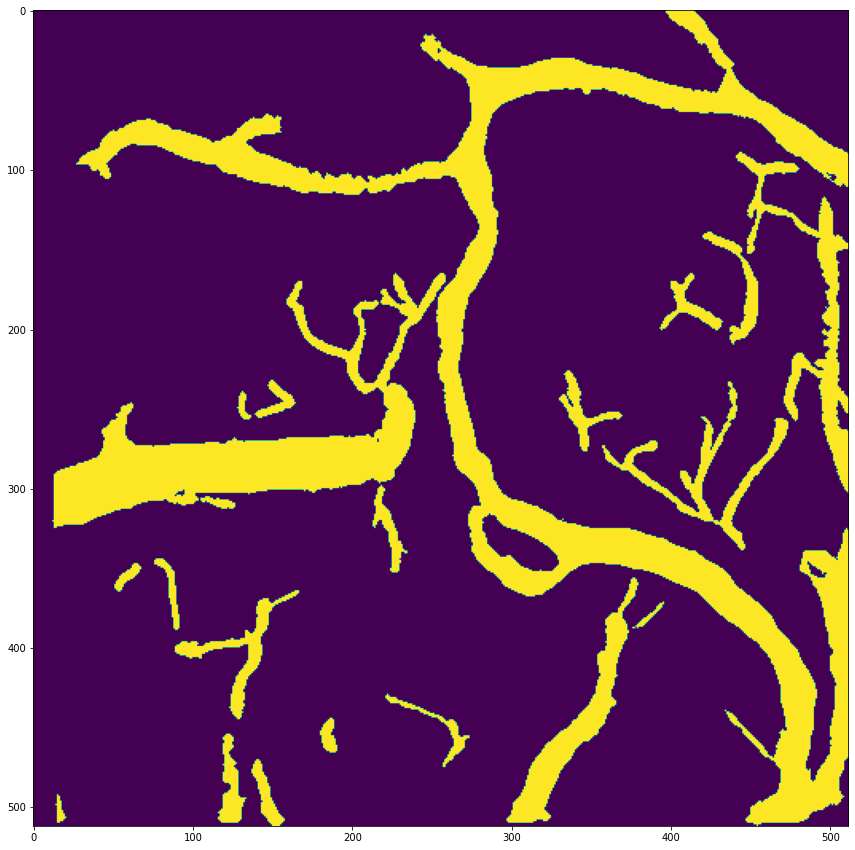

 37%|███▋      | 41/111 [03:02<07:20,  6.29s/it]

matt_raw_warped_single_upsampled_seg/20201221_38-XYZres240_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres233_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres233_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres236_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres236_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres237_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres237_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres240_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres241_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20201221_38-XYZres241_warped_seg.npy


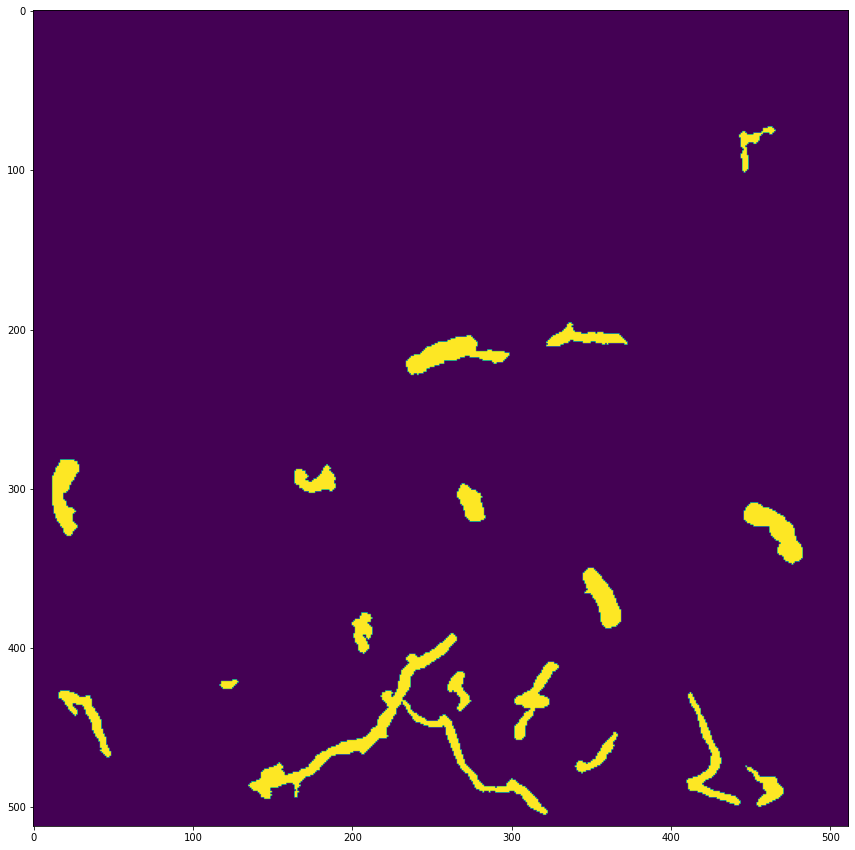

 38%|███▊      | 42/111 [06:02<16:37, 14.46s/it]

matt_raw_warped_single_upsampled_seg/20202112_40-XYZres243_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres243_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres246_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres246_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres247_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres251_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres251_warped_seg.npy


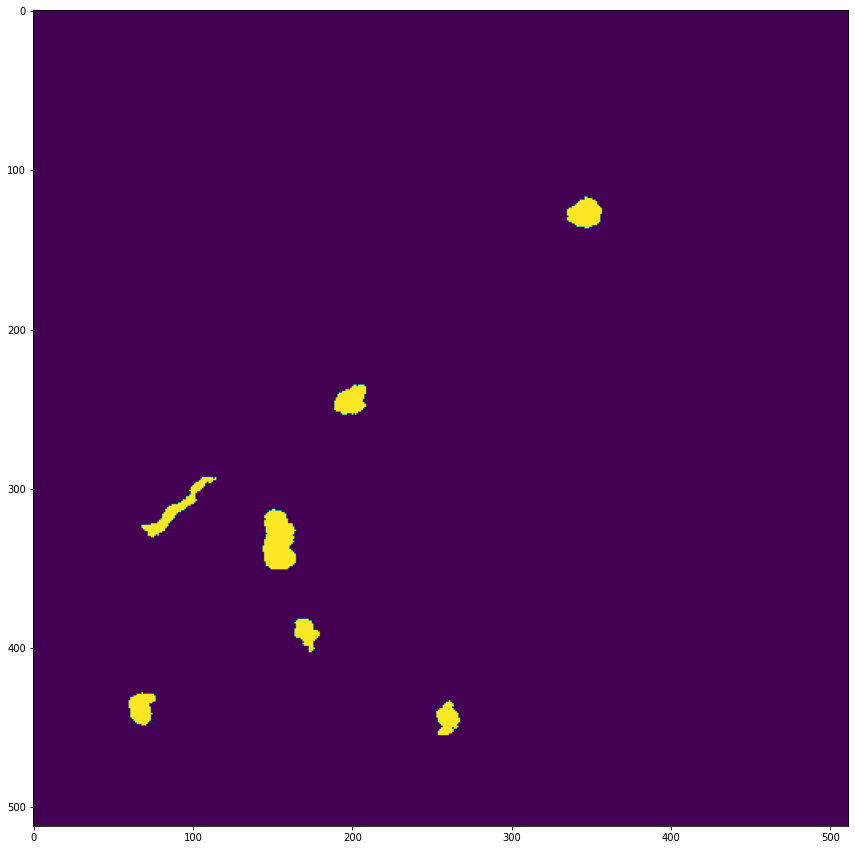

 39%|███▊      | 43/111 [08:21<25:18, 22.33s/it]

matt_raw_warped_single_upsampled_seg/20202112_40-XYZres244_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres244_warped_seg.npy


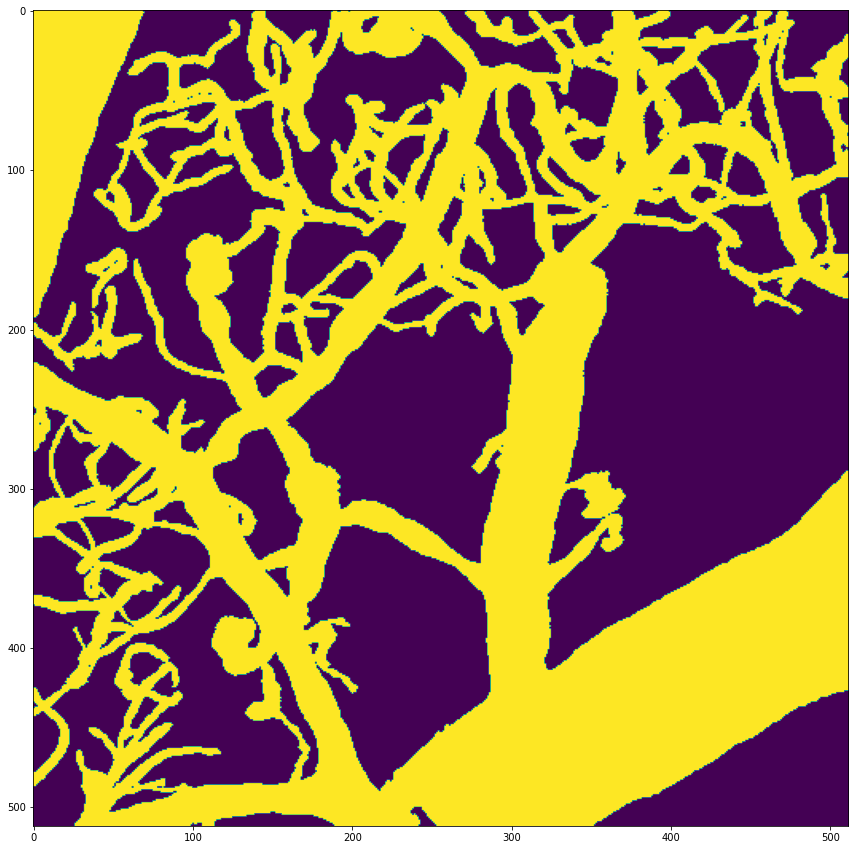

 40%|███▉      | 44/111 [09:04<26:49, 24.02s/it]

matt_raw_warped_single_upsampled_seg/20202112_40-XYZres248_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres248_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres249_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20202112_40-XYZres249_warped_seg.npy


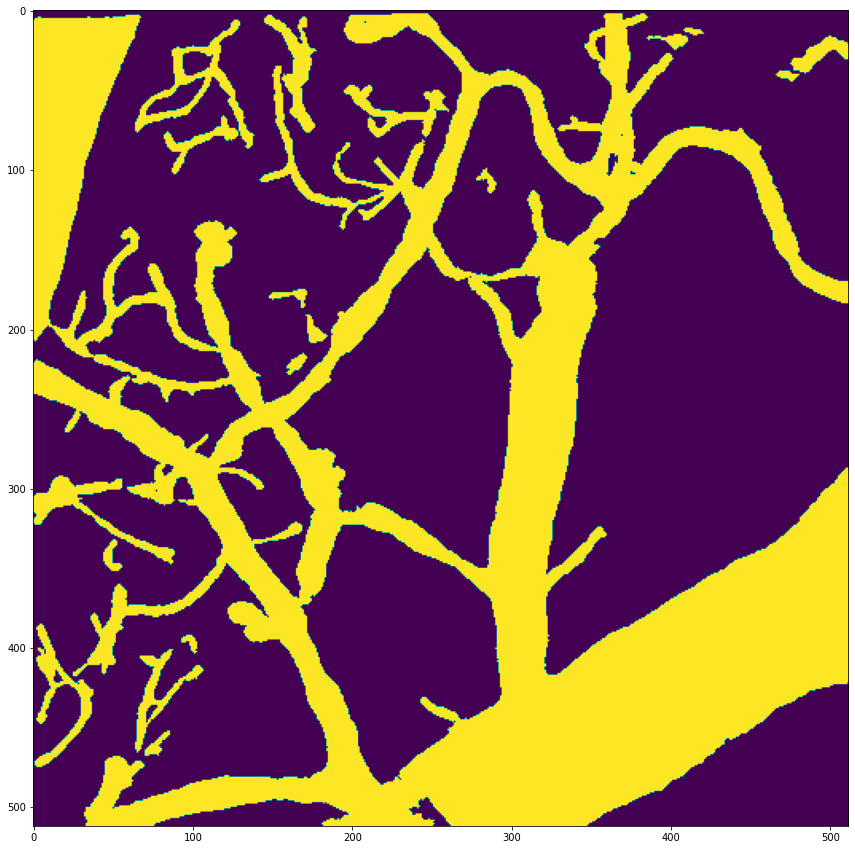

 41%|████▏     | 46/111 [10:23<29:09, 26.92s/it]

matt_raw_warped_single_upsampled_seg/20210619_48-XYZres302_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres302_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres303_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres303_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres306_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres306_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres307_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres307_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres310_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_48-XYZres310_warped_seg.npy


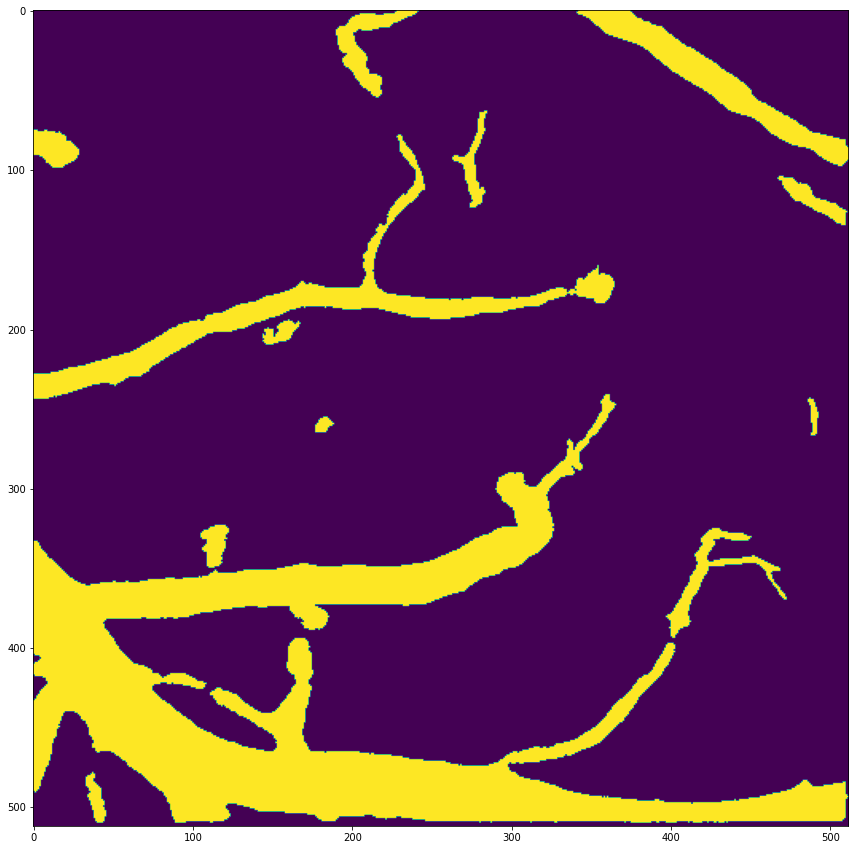

 44%|████▍     | 49/111 [13:26<38:02, 36.82s/it]

matt_raw_warped_single_upsampled_seg/20210619_49-XYZres322_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres315_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres315_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres318_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres318_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres319_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres319_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres322_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres323_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210619_49-XYZres323_warped_seg.npy


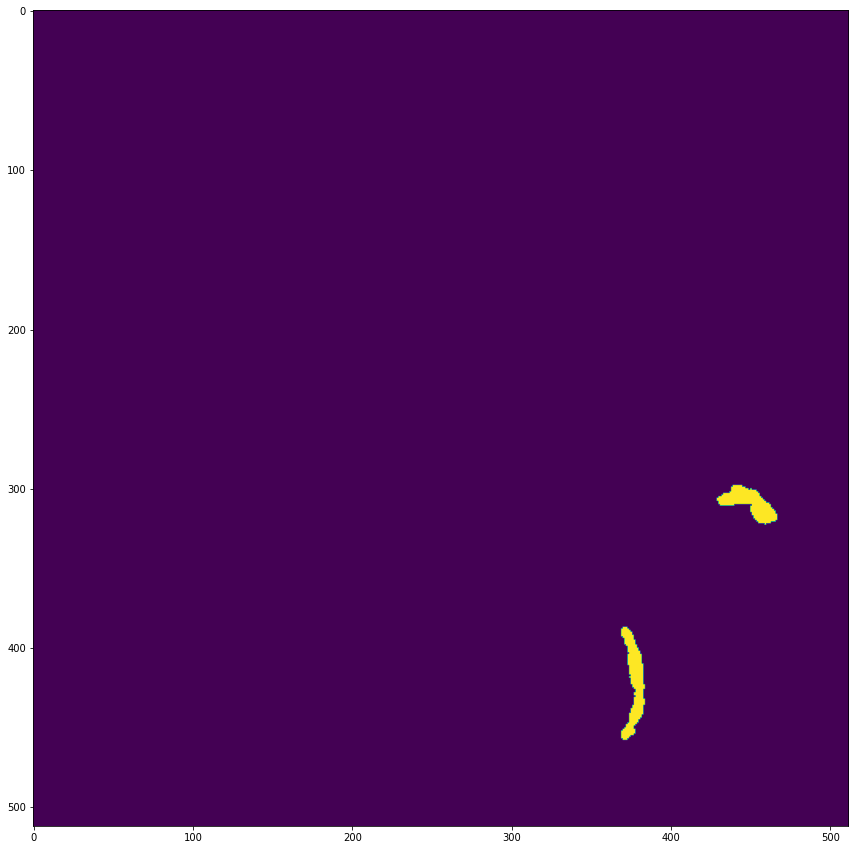

 47%|████▋     | 52/111 [16:22<42:29, 43.22s/it]

matt_raw_warped_single_upsampled_seg/20210710_51-XYZres297_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres297_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres298_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres298_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres301_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres301_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres302_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres302_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres305_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_51-XYZres305_warped_seg.npy


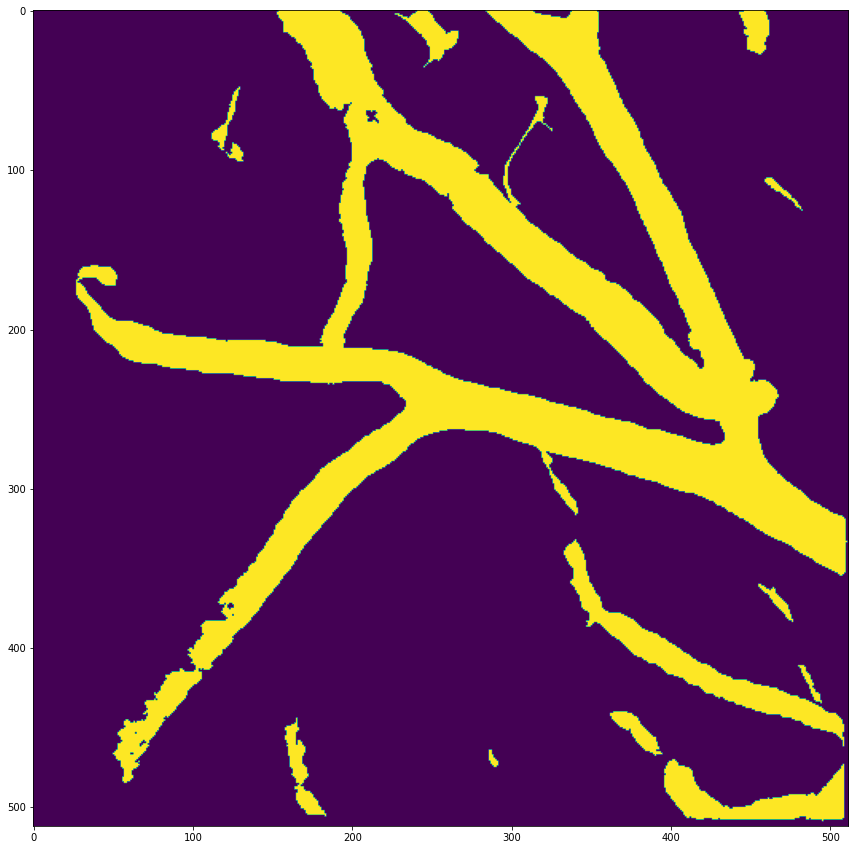

 49%|████▊     | 54/111 [19:23<50:52, 53.55s/it]

matt_raw_warped_single_upsampled_seg/20210710_55-XYZres349_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_55-XYZres348_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_55-XYZres348_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_55-XYZres349_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_55-XYZres350_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_55-XYZres350_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_55-XYZres352_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20210710_55-XYZres352_warped_seg.npy


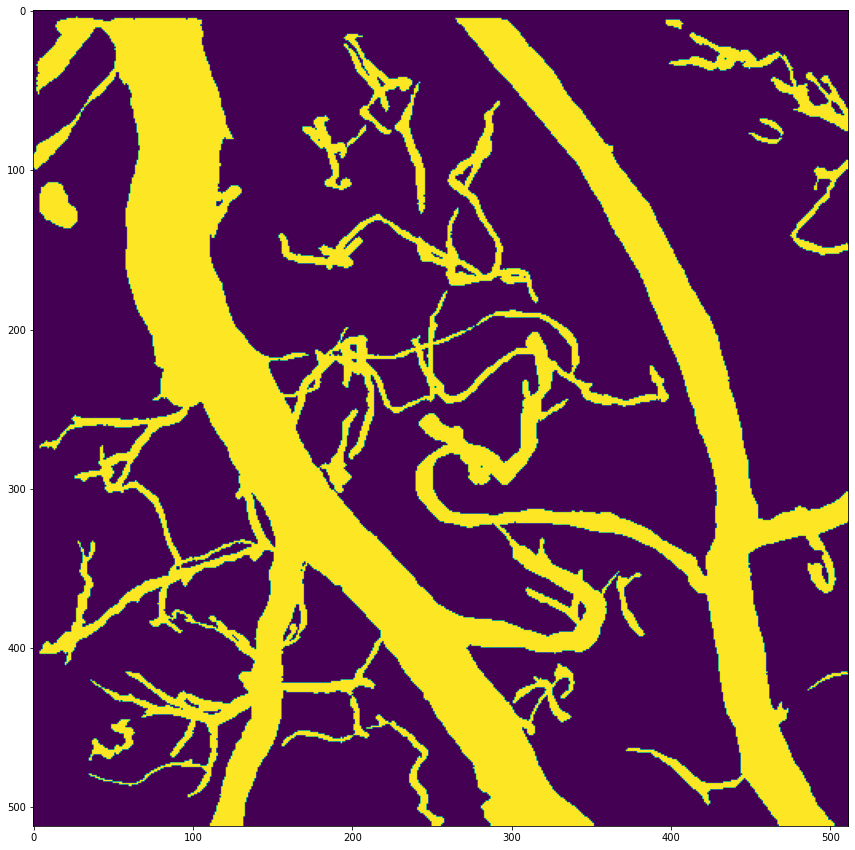

 52%|█████▏    | 58/111 [21:50<41:37, 47.13s/it]

matt_raw_warped_single_upsampled_seg/20220129_67-XYZres387_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres383_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres383_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres384_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres384_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres387_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres388_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres388_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres391_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres391_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres394_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres394_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20220129_67-XYZres395_0001_warped_seg.npy
mat

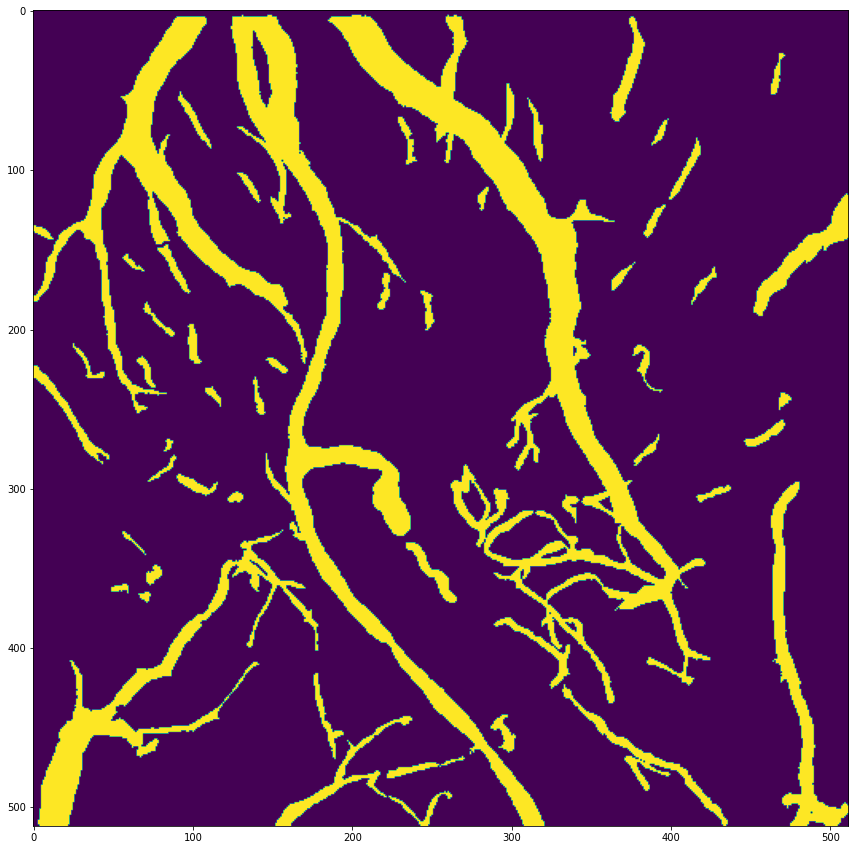

 72%|███████▏  | 80/111 [26:04<09:41, 18.76s/it]

matt_raw_warped_single_upsampled_seg/20230426_01-XYZres438_0001_warped_seg.npy


 72%|███████▏  | 80/111 [26:14<09:41, 18.76s/it]

matt_raw_warped_single_upsampled_seg/20230426_01-XYZres434_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230426_01-XYZres434_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230426_01-XYZres435_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230426_01-XYZres435_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230426_01-XYZres438_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230426_01-XYZres442_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230426_01-XYZres442_warped_seg.npy


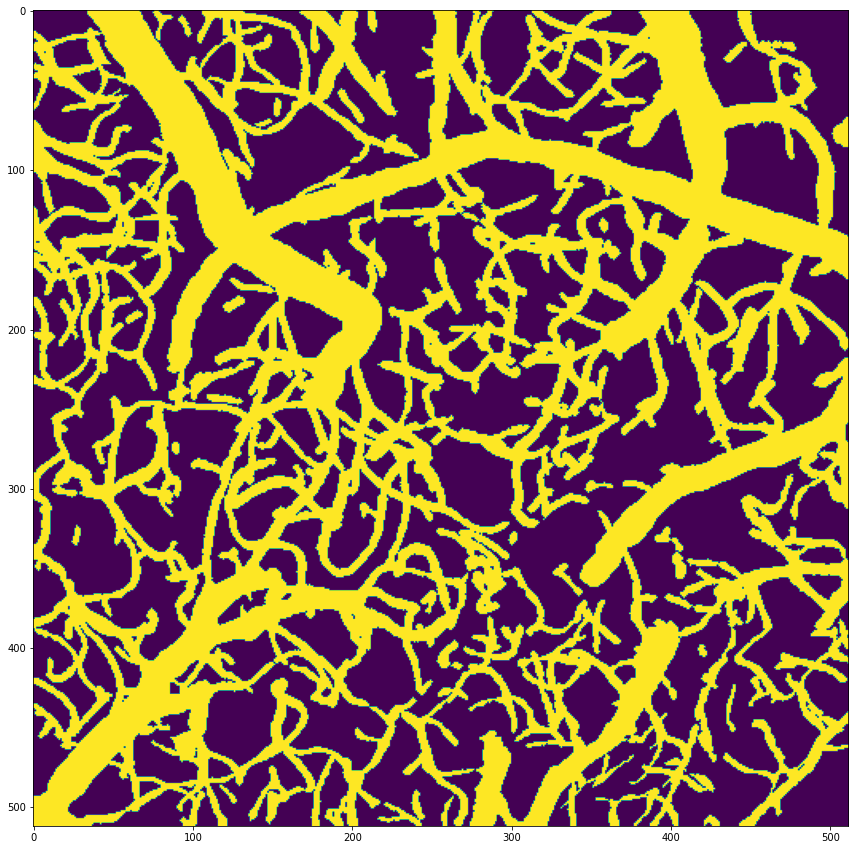

 76%|███████▌  | 84/111 [29:07<10:54, 24.25s/it]

matt_raw_warped_single_upsampled_seg/20230510_02-XYZres450_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230510_02-XYZres446_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230510_02-XYZres446_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230510_02-XYZres447_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230510_02-XYZres447_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230510_02-XYZres450_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230510_02-XYZres451_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230510_02-XYZres451_warped_seg.npy


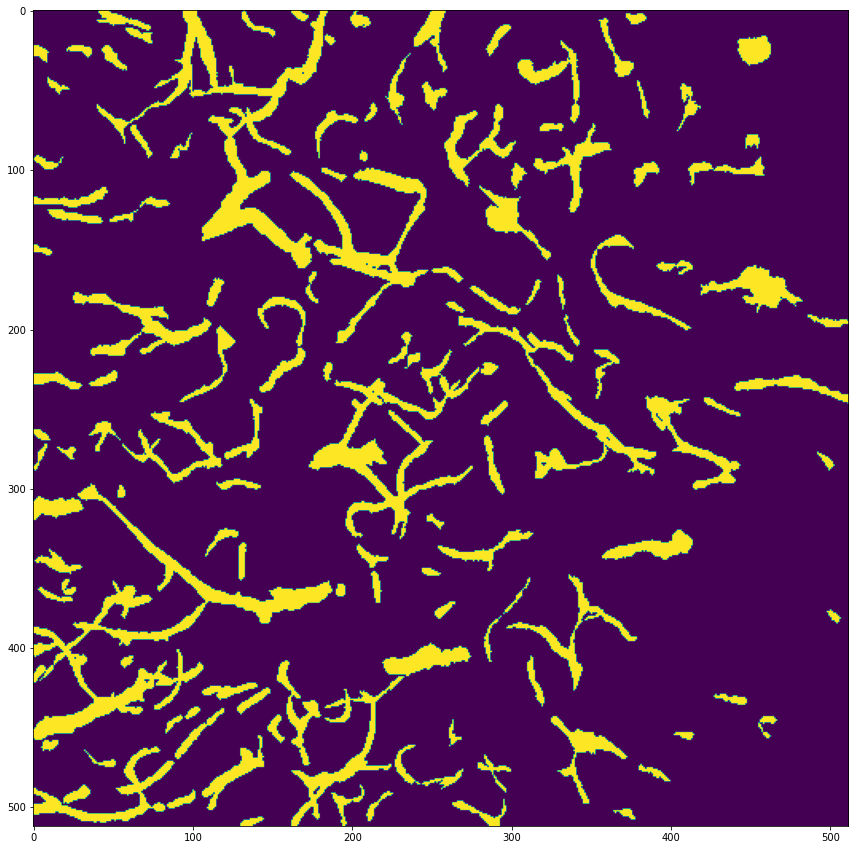

 77%|███████▋  | 86/111 [32:13<13:45, 33.02s/it]

matt_raw_warped_single_upsampled_seg/20230518_03-XYZres456_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230518_03-XYZres453_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230518_03-XYZres453_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230518_03-XYZres456_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230518_03-XYZres460_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230518_03-XYZres460_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230518_03-XYZres461_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/20230518_03-XYZres461_warped_seg.npy


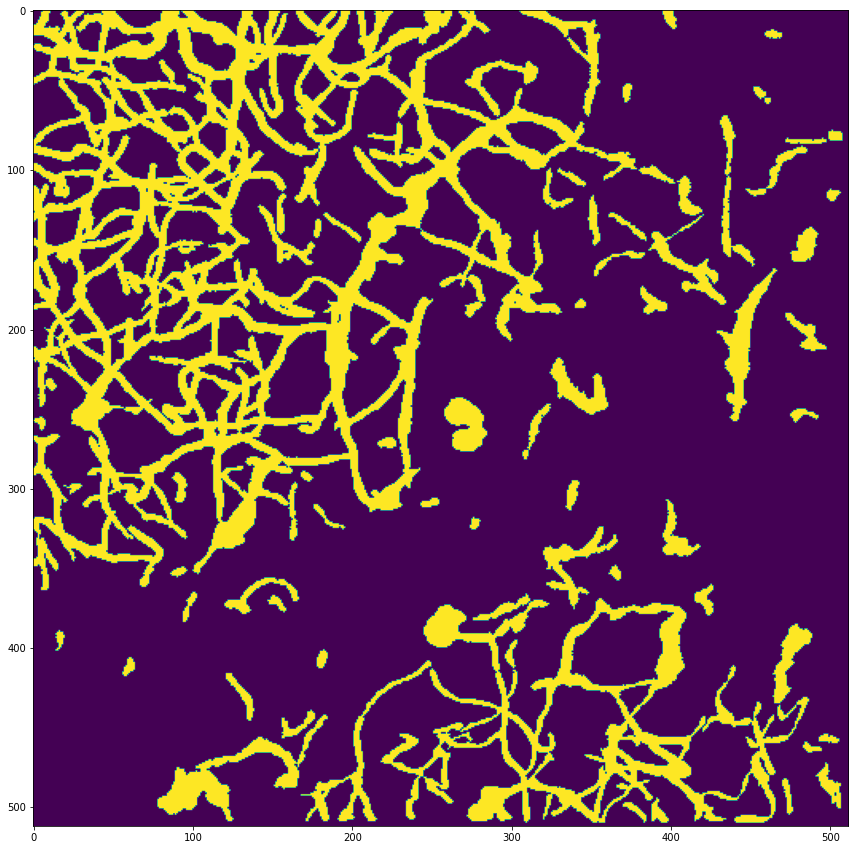

 79%|███████▉  | 88/111 [34:47<15:13, 39.74s/it]

matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres028_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres028_warped_seg.npy
matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres030_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres030_warped_seg.npy
matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres032_0001_warped_seg.npy
matt_raw_warped_single_upsampled_seg/vbm08 Mar 27 2020-XYZres032_warped_seg.npy


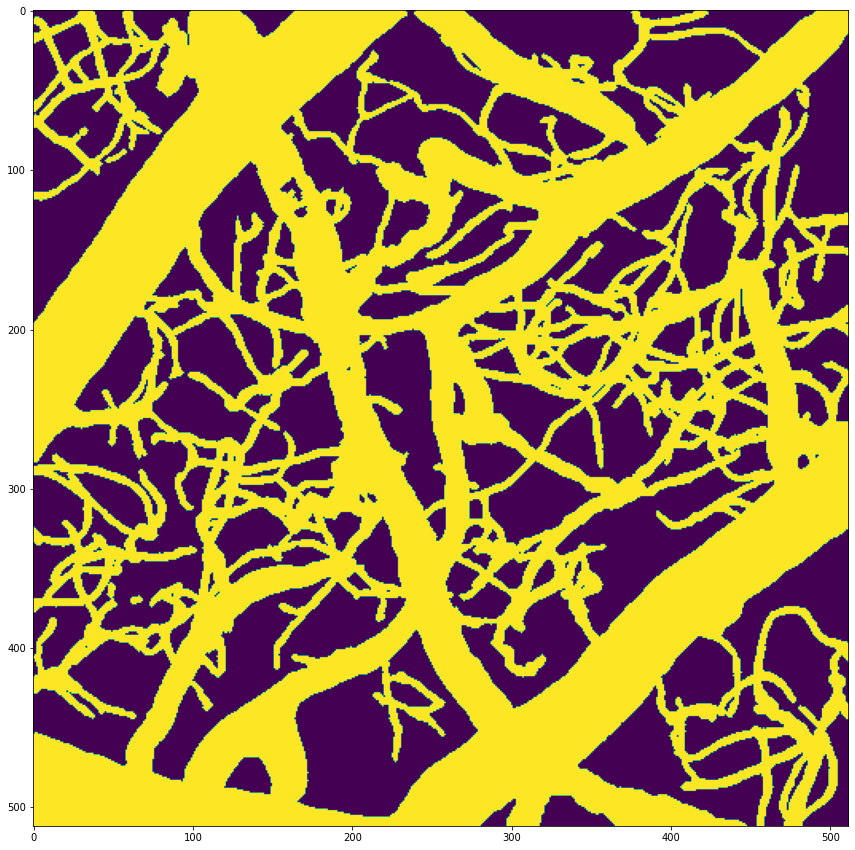

100%|██████████| 111/111 [36:40<00:00, 19.82s/it]


In [21]:
res = []
for image in tqdm(images[:]):
    if not os.path.exists(re.sub('_warped_seg.npy','_seg_warped_single_int.mat',re.sub('_0001','',image))) or (time.time() - os.path.getmtime(re.sub('_warped_seg.npy','_seg_warped_single_int.mat',re.sub('_0001','',image))))/3600>48:
        print(image)
        img = binary_dilation(np.load(image))
        _img = np.copy(img)
        key = [x for x in list(dic.keys()) if x in image][0]
        mov_files = [re.sub(key,x,image) for x in dic[key]]
        mov_files = sorted(mov_files + [re.sub('_0001_warped_seg.npy','_warped_seg.npy',x) for x in mov_files])
        mov_files.append(re.sub('_0001_warped_seg.npy','_warped_seg.npy',image))
        mov_files = [x for x in mov_files if x != image]
        mov_files = sorted(mov_files)
        mov_files = np.unique(mov_files)
        mov_files = [x for x in mov_files if os.path.exists(x)]
        #print(mov_files)
        #break
        mut_info = []
        for i in mov_files:
            img_0001 = binary_dilation(np.load(i))
            _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
            mut_info.append(_mut_info)
            if _mut_info > 0.1:
                #img += img_0001
                img = img * img_0001
                print(i)
        seg = img
        seg[seg!=0] = seg[seg!=0]/seg[seg!=0]
        seg = (seg==1)*1
        seg = seg.astype('int8')
        seg = binary_closing(binary_closing(binary_closing(fill_holes(seg))))
        seg = remove_small_comps_3d(seg,thresh=250)
        #print(mut_info)
        #print(mov_files)
        plt.imshow(np.max(seg,axis=2))
        plt.show()
        res += mut_info
        savemat(re.sub('_warped_seg.npy','_seg_warped_single_int.mat',re.sub('_0001','',image)),{'FinalImage':fill_holes(binary_closing(seg))})
        np.save(re.sub('_warped_seg.npy','_seg_warped_single_int.npy',re.sub('_0001','',image)),fill_holes(binary_closing(seg)))

In [ ]:
print(np.mean(res))
print(np.std(res))

0.3946770936337705
0.2070843727443032


# Generate Graphs

In [22]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files_seg_0001 = directory.glob('*_skel_warped_single_int.mat')
#files_seg_0001 = directory.glob('*.pickle')
files_seg_0001 = sorted([x.as_posix() for x in files_seg_0001])
#files_seg_0001 = [x for x in files_seg_0001 if any(y in x for y in ['_14-','_17-','_7-','_9-','_20-','23-','49-','56-','68-','65-','61-'])]
#files_seg_0001 = [x for x in files_seg_0001 if '45-XYZres290' in x]
#files_seg_0001 = [x for x in files_seg_0001 if '61-XYZres384_0001' not in x]
len(files_seg_0001)
#print(files_seg_0001)

111

In [23]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files_seg_0001 = directory.glob('*_0001_warped_seg.npy')
files_seg_0001 = sorted([x.as_posix() for x in files_seg_0001])
files_seg_0001 = [x for x in files_seg_0001 if  any(y in x for y in list(dic.keys()))]
#files_seg_0001 = [re.sub('_0001','',x) for x in files_seg_0001]
#files_seg_0001 = [x for x in files_seg_0001 if any(y in x for y in ['14-','49-','56-','68-','65-','61-'])]
#files_seg_0001 = [x for x in files_seg_0001 if any(y in x for y in ['_14-','_17-','_7-','_9-','_20-','23-','49-','56-','68-','65-','61-'])]
np.random.shuffle(files_seg_0001)
#files_seg_0001 = [x for x in files_seg_0001 if '61-XYZres384_0001' not in x]
len(files_seg_0001)
#print(files_seg_0001[0])

111

In [29]:
np.random.shuffle(files_seg_0001)
for file_0001 in tqdm(files_seg_0001[:]):
    if not os.path.exists(re.sub('_warped_seg.npy','_warped_int.pickle',file_0001)) or (time.time() - os.path.getmtime(re.sub('_warped_seg.npy','_warped_int.pickle',file_0001)))/3600>48:
        if os.path.exists(re.sub('_0001_warped_seg.npy','_skel_warped_single_int.mat',file_0001)):
            file = file_0001
            skel_file = re.sub('_0001_warped_seg.npy','_skel_warped_single_int.mat',file)
            skel = loadmat(skel_file)['FilteredImage']
            if np.sum(skel) != 0:
                graph = sknw.build_sknw(skel, multi=False)
                print(len(graph.edges))
                while len(list(nx.selfloop_edges(graph)))>0:
                    if len(list(nx.selfloop_edges(graph))) !=0:
                        for edge in list(nx.selfloop_edges(graph)):
                            skel[graph[edge[0]][edge[1]]['pts'][1:-1,0],graph[edge[0]][edge[1]]['pts'][1:-1,1],graph[edge[0]][edge[1]]['pts'][1:-1,2]] = 0
                    for edge in graph.edges:
                        if (graph.degree(edge[0]) == 1 and graph.degree(edge[1]) > 2) or (graph.degree(edge[1]) == 1 and graph.degree(edge[0]) > 2):
                            if graph[edge[0]][edge[1]]['weight']<20:
                                skel[graph[edge[0]][edge[1]]['pts'][1:-1,0],graph[edge[0]][edge[1]]['pts'][1:-1,1],graph[edge[0]][edge[1]]['pts'][1:-1,2]] = 0
                    graph = sknw.build_sknw(skel, multi=False)
                for edge in graph.edges:
                    if (graph.degree(edge[0]) == 1 and graph.degree(edge[1]) > 2) or (graph.degree(edge[1]) == 1 and graph.degree(edge[0]) > 2):
                        if graph[edge[0]][edge[1]]['weight']<20:
                            skel[graph[edge[0]][edge[1]]['pts'][1:-1,0],graph[edge[0]][edge[1]]['pts'][1:-1,1],graph[edge[0]][edge[1]]['pts'][1:-1,2]] = 0
                graph = sknw.build_sknw(skel, multi=False)
                graph.remove_nodes_from(list(nx.isolates(graph)))
                print(len(graph.edges))
                #print(len(list(nx.isolates(graph))))
                io.imsave(re.sub('_0001_warped_seg.npy','_single_skel_int.tif',file),skel)
                nx.write_gpickle(graph,re.sub('_warped_seg.npy','_warped_int.pickle',file))
                #key = [x for x in list(dic.keys()) if x in file][0]
                #mov_files = [re.sub(key,x,file) for x in dic[key]]
                #mov_files = sorted(mov_files + [re.sub('_0001','',x) for x in mov_files])
                #mov_files.append(re.sub('_0001','',file))
                #seg = np.load(re.sub('_0001','',file))
                #for _file in mov_files:
                #    if os.path.exists(_file):
                #        seg_0001 = np.load(_file)
                #        _mut_info = normalized_mutual_info_score(seg.flatten(),seg_0001.flatten()) # calculate mutual information between masks, judges registration
                #        if _mut_info > 0.1:
                #            print('matched')
                #            nx.write_gpickle(graph,re.sub('_warped_seg.npy','_warped.pickle',_file))

100%|██████████| 111/111 [00:03<00:00, 35.08it/s]


In [30]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files = directory.glob('*_warped_int.pickle')
files = sorted([x.as_posix() for x in files])
print(len(files))

111


In [35]:
res_num_edges = []
res_num_nodes = []
res_mean_path_length = []
res_num_terminal_nodes = []
for file in tqdm(files):
    graph = nx.read_gpickle(file)
    res_num_edges.append(len(graph.edges))
    res_num_nodes.append(len(graph.nodes))
    res_mean_path_length.append(np.mean(nx.to_pandas_edgelist(graph)['weight']))
    res_num_terminal_nodes.append(np.sum([d == 1 for n,d in graph.degree()]))

100%|██████████| 111/111 [00:00<00:00, 412.38it/s]


In [36]:
print(np.mean(res_num_edges))
print(np.std(res_num_edges))
print(np.mean(res_num_nodes))
print(np.std(res_num_nodes))
print(np.mean(res_mean_path_length))
print(np.std(res_mean_path_length))
print(np.mean(res_num_terminal_nodes))
print(np.std(res_num_terminal_nodes))

110.50450450450451
101.7417569872104
132.80180180180182
108.3362150541037
101.97724031984136
25.64978795434592
85.92792792792793
64.34993181453532


# write vessel measurments to graph files

In [17]:
directory = Path('matt_raw_warped_single_upsampled_seg')
files = directory.glob('*_warped.pickle')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if '-' in x]
#files = [x for x in files if '51-' in x]
#files = [x for x in files if '20220129_67-XYZres386' not in x]
files = [x for x in files if '04-XYZres464' not in x]
files = [x for x in files if '04-XYZres465' not in x]
files = [x for x in files if '04-XYZres472' not in x]
files = [x for x in files if '04-XYZres469' not in x]
files = [x for x in files if '04-XYZres468' not in x]

files = [x for x in files if '02-XYZres448' not in x]
files = [x for x in files if '02-XYZres444' not in x]
files = [x for x in files if '02-XYZres449' not in x]
files = [x for x in files if '02-XYZres452' not in x]
files = [x for x in files if '02-XYZres445' not in x]
#
#files = [x for x in files if '76-XYZres464' not in x]
#files = [x for x in files if '76-XYZres466_0001' not in x]
#files = [x for x in files if '67-XYZres395' not in x]
#files = [x for x in files if '67-XYZres394_0001' not in x]
#files = [x for x in files if '76-XYZres463' not in x]
#files = [x for x in files if '73-XYZres429' not in x]
#
#files = [x for x in files if '67-XYZres392' not in x]
#files = [x for x in files if '67-XYZres394' not in x]
#files = [x for x in files if '65-XYZres408' not in x]
#files = [x for x in files if '76-XYZres466' not in x]
#files = [x for x in files if '73-XYZres430_0001' not in x]
#files = [x for x in files if '73-XYZres430' not in x]
#76-XYZres464
print(len(files))
files = [x for x in files if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii.pickle',x)))]
print(len(files))
files = [x for x in files if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii_forepaw.pickle',x)))]
np.random.shuffle(files)
print(len(files))
#files

804
135
10


In [ ]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)
for file in tqdm(files):
    if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii.pickle',file))):
        graph = nx.read_gpickle(file)
        print(len(graph.edges))
        if len(graph.edges) < 1500:
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('_0001','',re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]) in df[sheet_name].values:
                    subj = sheet_name
                    if (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                        if subj in ["TBI07_3D",
                                    "TBI11_3D",
                                    "TBI22_3D",
                                    "TBI31_3D",
                                    "TBI38_3D",
                                    "SHAM09_3D",
                                    "SHAM12_3D",
                                    "SHAM23_3D",
                                    "SHAM32_3D",
                                    'TBI38_3D',
                                    'TBI6_3D',
                                    'SHAM7_3D',
                                    'TBI43_3D',
                                    'TBI45_3D',
                                    'SHAM53_3D',
                                    'SHAM56_3D',
                                    'SHAM55_3D']:
                            gender = 'male'
                        else:
                            gender = 'female'
                        treatment = re.sub('SHA','SHAM',subj[0:3])
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] ==  re.sub('_0001','',re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1])]
                        if _tmp['Unnamed: 12'].iloc[0] == 'raster':
                            img_file = re.sub('matt_raw_warped_single_upsampled_seg','matt_raw_warped_single',re.sub('_warped.pickle','_warped.tif',file))
                            seg_file = re.sub('_warped.pickle','_warped_seg.npy',file)
                            mean_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_mean.npy',file))
                            std_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_2x_std.npy',file))
                            img = io.imread(img_file)
                            img_ch2 = sp.ndimage.zoom(np.swapaxes(img[:,1,:,:],0,2),(1,1,2.645833333))
                            img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))
                            seg = np.load(seg_file)
                            mean = np.load(mean_file)
                            std = np.load(std_file)
                            seg_dst = distance_transform_edt(seg)
                            nrn_dst = np.load(re.sub('_warped.pickle','_warped_seg_nrn_dst.npy',file))
                            wavelength = _tmp['Unnamed: 11'].iloc[0]
                            power_per = _tmp['Unnamed: 10'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            a, b, c = np.mgrid[-15:16:1, -15:16:1, -15:16:1]
                            abc = np.dstack([a.flat,b.flat, c.flat])
                            mu = np.array([0,0,0])
                            sigma = np.array([0.636,0.127,0.127])
                            covariance = np.diag(sigma**2)
                            d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
                            d = d.reshape((len(a),len(b),len(c)))
                            deconv_img = np.copy(img)
                            deconv_img =  1023 * restoration.richardson_lucy(img/1023.0, d, iterations=10) - 1023 * restoration.richardson_lucy(img_ch2/1023.0, d, iterations=10)
                            deconv_img = np.int16(deconv_img)
                            
                            if treatment != 'vbm' and treatment != 'C57':
                                age = _tmp['Unnamed: 14'].iloc[0]
                                days_post_injury = _tmp['Unnamed: 15'].iloc[0]
                            else:
                                age = 'unknown'
                                days_post_injury = 'unknown'
                            for i in tqdm(range(len(graph.edges))):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii == 0:
                                    _pred_radii =1
                                
                                _box_fit = max([np.int16(_pred_radii_max)+10, 15])
                                #path_grad = np.gradient(path,edge_order=2)[0]
                                path_smooth = np.float32(np.copy(path))
                                for k in range(len(path[0])):
                                    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
                                path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                res_fwhm = []
                                X = np.arange(-1*_box_fit,_box_fit+1,1)
                                Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                x,y = np.meshgrid(X,Y)
                                x = x.flatten()
                                y = y.flatten()
                                z = np.zeros(len(x))
                                xy = np.vstack([x,y,z])
                                
                                
                                res_fwhm = []
                                
                                res_fwhm_sigma = []
                                
                                def calc_fwhm_path(I):
                                    point_grad = path_grad[I]
                                    point = path[I]
                                    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                        rotated = xy.T + point
                                    else:
                                        rotated = _rotmat(point_grad,xy.T) + point
                                    points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                                        deconv_img,
                                                                        rotated.T, 
                                                                        order=3,
                                                                        mode='constant')
                                    
                                            
                                    points_img = np.reshape(points_img,(len(X),len(Y)))
                                    points_img_no_smooth = np.copy(points_img)
                                    points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)

                                    
                                    
                                    _point = np.array(np.arange(0,_pred_radii+20,sampling))
                                    _zeros = np.zeros(len(_point))
                                    _point = np.array([_point,_zeros])
                                    _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
                                    
                                    _res = []
                                    
                                    #fig,ax = plt.subplots(1)
                                    #ax.set_aspect('equal')
                                    #ax.imshow(points_img_no_smooth,
                                    #          vmin = 0,
                                    #          vmax = np.max(deconv_img))
                                    #ax.scatter(_centre[0],_centre[1])
                                    for deg in np.arange(0,360,10):
                                        rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                                        rot_point[0] = rot_point[0] + _centre[0]
                                        rot_point[1] = rot_point[1] + _centre[1]
                                        points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                                                 rot_point, 
                                                                                 order=3,
                                                                                 cval=0)
                                        points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                                        points_vals_grad = np.gradient(points_vals)
                                        _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                        if _.shape[1] != 0:
                                            points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            #ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                        else:
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            #ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                    _res = np.array(_res)
                                    _res = _res[~np.isnan(_res)]
                                    _res = _res[np.where(_res!=0)]
                                    _mean = np.mean(_res)
                                    _std = np.std(_res)
                                    _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
                                    _res = _res[_mask]
                                    radii = np.mean(_res)
                                    radii_std = np.std(_res)
                                    circ = Circle(_centre,radii,fill=False)
                                    #ax.add_patch(circ)
                                    #ax.set_title(radii)
                                    #fig.savefig('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                    #plt.clf()
                                    
                                        
                                    return radii, radii_std
                                
                                pool = multiprocessing.Pool(64)
                                _vals, _vals_sigma = zip(*pool.map(calc_fwhm_path, range(len(path))))
                                #images = []
                                #for I in tqdm(range(len(path))):
                                #    images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png'))
                                #    os.remove('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                #imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'.gif', images, format='GIF', fps=2)
                                
                                _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii'] = np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_std'] = np.std(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_neuron_distance'] = np.mean(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_std'] = np.std(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_min'] = np.min(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['gender'] = gender
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights'] = _vals
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty'] = _vals_sigma
                                #graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight'] = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight']
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0z'] = path[0][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0y'] = path[0][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0x'] = path[0][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1z'] = path[-1][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1y'] = path[-1][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1x'] = path[-1][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_depth'] = np.mean(path[:,0])
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['euclidean-dst'] = np.sqrt(np.sum(np.square(path[-1]-path[0])))
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['subject'] = subj
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['treatment'] = treatment
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['wavelength'] = wavelength
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['power'] = power_per
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['age'] = age
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['days_post_injury'] = days_post_injury
                            nx.write_gpickle(graph, re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii.pickle',file)))

  0%|          | 0/804 [00:00<?, ?it/s]

12


/tmp/ipykernel_2389584/1496374203.py:66: FutureWarning:

`iterations` is a deprecated argument name for `richardson_lucy`. It will be removed in version 1.0. Please use `num_iter` instead.


  0%|          | 1/804 [06:05<81:33:14, 365.62s/it]

484



  0%|          | 0/484 [00:00<?, ?it/s]/tmp/ipykernel_2389584/1496374203.py:199: RuntimeWarning:

invalid value encountered in sqrt


 35%|███▍      | 168/484 [1:00:56<3:10:29, 36.17s/it]/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

/lustre06/project/6023374/rozakmat/mona

In [21]:
files = sorted(files)
#files

In [22]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)
for file in tqdm(files):
    if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii.pickle',file))):
        #print('yes')
        graph = nx.read_gpickle(file)
        print(len(graph.edges))
        if len(graph.edges) < 1500:
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('_0001','',re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]) in df[sheet_name].values:
                    #print('a')
                    subj = sheet_name
                    if (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                        if subj in ["TBI7_3D",
                                    "SHAM12_3D",
                                    "TBI11_3D",
                                    "SHAM9_3D",
                                    "TBI22_3D",
                                    "TBI31_3D",
                                    "TBI38_3D",
                                    "SHAM09_3D",
                                    "SHAM23_3D",
                                    "SHAM32_3D",
                                    'TBI38_3D',
                                    'TBI6_3D',
                                    'SHAM7_3D',
                                    'TBI43_3D',
                                    'TBI45_3D',
                                    'SHAM53_3D',
                                    'SHAM56_3D',
                                    'SHAM55_3D',
                                    'SHAM68_3D']:
                            gender = 'male'
                        elif subj in ["TBI14_3D",
                                      "SHAM17_3D",
                                      "TBI18_3D",
                                      "SHAM20_3D",
                                      "TBI26_3D",
                                      "TBI28_3D",
                                      "SHAM35_3D",
                                      "TBI33_3D",
                                      "TBI40_3D",
                                      "SHAM4_3D",
                                      "TBI51_3D",
                                      "SHAM64_3D",
                                      "SHAM63_3D",
                                      "TBI61_3D",
                                      "TBI48_3D",
                                      "TBI49_3D",
                                      "SHAM67_3D",
                                      "TBI65_3D",
                                      "TBI70_3D",
                                      "SHAM73_3D"]:
                            gender = 'female'
                        treatment = re.sub('SHA','SHAM',subj[0:3])
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] ==  re.sub('_0001','',re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1])]
                        #print(_tmp)
                        if _tmp['Unnamed: 12'].iloc[0] == 'raster':
                            #print('yes')
                            img_file = re.sub('matt_raw_warped_single_upsampled_seg','matt_raw_warped_single',re.sub('_warped.pickle','_warped.tif',file))
                            seg_file = re.sub('_warped.pickle','_warped_seg.npy',file)
                            mean_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_mean.npy',file))
                            std_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_2x_std.npy',file))
                            img = io.imread(img_file)
                            img_ch2 = sp.ndimage.zoom(np.swapaxes(img[:,1,:,:],0,2),(1,1,2.645833333))
                            img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))
                            seg = np.load(seg_file)
                            mean = np.load(mean_file)
                            std = np.load(std_file)
                            seg_dst = distance_transform_edt(seg)
                            nrn_dst = np.load(re.sub('_warped.pickle','_warped_seg_nrn_dst.npy',file))
                            wavelength = _tmp['Unnamed: 11'].iloc[0]
                            power_per = _tmp['Unnamed: 10'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            a, b, c = np.mgrid[-15:16:1, -15:16:1, -15:16:1]
                            abc = np.dstack([a.flat,b.flat, c.flat])
                            mu = np.array([0,0,0])
                            sigma = np.array([0.636,0.127,0.127])
                            covariance = np.diag(sigma**2)
                            d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
                            d = d.reshape((len(a),len(b),len(c)))
                            deconv_img = np.copy(img)
                            deconv_img =  1023 * restoration.richardson_lucy(img/1023.0, d, iterations=10) - 1023 * restoration.richardson_lucy(img_ch2/1023.0, d, iterations=10)
                            deconv_img = np.int16(deconv_img)
                            
                            if treatment != 'vbm':
                                age = _tmp['Unnamed: 14'].iloc[0]
                                days_post_injury = _tmp['Unnamed: 15'].iloc[0]
                            else:
                                age = 'unknown'
                                days_post_injury = 'unknown'
                            for i in tqdm(range(len(graph.edges))):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii == 0:
                                    _pred_radii =1
                                
                                _box_fit = max([np.int16(_pred_radii_max)+10, 15])
                                #path_grad = np.gradient(path,edge_order=2)[0]
                                path_smooth = np.float32(np.copy(path))
                                for k in range(len(path[0])):
                                    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
                                path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                res_fwhm = []
                                X = np.arange(-1*_box_fit,_box_fit+1,1)
                                Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                x,y = np.meshgrid(X,Y)
                                x = x.flatten()
                                y = y.flatten()
                                z = np.zeros(len(x))
                                xy = np.vstack([x,y,z])
                                
                                
                                res_fwhm = []
                                
                                res_fwhm_sigma = []
                                
                                def calc_fwhm_path(I):
                                    point_grad = path_grad[I]
                                    point = path[I]
                                    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                        rotated = xy.T + point
                                    else:
                                        rotated = _rotmat(point_grad,xy.T) + point
                                    points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                                        deconv_img,
                                                                        rotated.T, 
                                                                        order=3,
                                                                        mode='constant')
                                    
                                            
                                    points_img = np.reshape(points_img,(len(X),len(Y)))
                                    points_img_no_smooth = np.copy(points_img)
                                    points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)

                                    
                                    
                                    _point = np.array(np.arange(0,_pred_radii+20,sampling))
                                    _zeros = np.zeros(len(_point))
                                    _point = np.array([_point,_zeros])
                                    _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
                                    
                                    _res = []
                                    
                                    fig,ax = plt.subplots(1)
                                    ax.set_aspect('equal')
                                    ax.imshow(points_img_no_smooth,
                                              vmin = 0,
                                              vmax = np.max(deconv_img))
                                    ax.scatter(_centre[0],_centre[1])
                                    for deg in np.arange(0,360,10):
                                        rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                                        rot_point[0] = rot_point[0] + _centre[0]
                                        rot_point[1] = rot_point[1] + _centre[1]
                                        points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                                                 rot_point, 
                                                                                 order=3,
                                                                                 cval=0)
                                        points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                                        points_vals_grad = np.gradient(points_vals)
                                        _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                        if _.shape[1] != 0:
                                            points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                        else:
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                    _res = np.array(_res)
                                    _res = _res[np.where(_res!=0)]
                                    _mean = np.mean(_res)
                                    _std = np.std(_res)
                                    _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
                                    _res = _res[_mask]
                                    radii = np.mean(_res)
                                    radii_std = np.std(_res)
                                    circ = Circle(_centre,radii,fill=False)
                                    #ax.add_patch(circ)
                                    ax.set_title(radii)
                                    fig.savefig('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                    plt.clf()
                                    
                                        
                                    return radii, radii_std
                                
                                pool = multiprocessing.Pool(8)
                                _vals, _vals_sigma = zip(*pool.map(calc_fwhm_path, range(len(path))))
                                images = []
                                for I in tqdm(range(len(path))):
                                    images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png'))
                                    os.remove('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'.gif', images, format='GIF', fps=2)
                                
                                _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii'] = np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_std'] = np.std(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_neuron_distance'] = np.mean(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_std'] = np.std(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_min'] = np.min(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['gender'] = gender
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights'] = _vals
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty'] = _vals_sigma
                                #graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight'] = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight']
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0z'] = path[0][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0y'] = path[0][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0x'] = path[0][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1z'] = path[-1][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1y'] = path[-1][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1x'] = path[-1][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_depth'] = np.mean(path[:,0])
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['euclidean-dst'] = np.sqrt(np.sum(np.square(path[-1]-path[0])))
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['subject'] = subj
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['treatment'] = treatment
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['wavelength'] = wavelength
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['power'] = power_per
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['age'] = age
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['days_post_injury'] = days_post_injury
                                break
                            break
                            #nx.write_gpickle(graph, re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii.pickle',file)))

100%|██████████| 12/12 [00:00<00:00, 70.10it/s]

2289
2289
1630
1630
1630
1630
1630
1630
1630
1630
1630
1630


In [23]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)

for file in tqdm(files):
    if not os.path.exists(re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii_forepaw.pickle',file))):
        graph = nx.read_gpickle(file)
        if len(graph.edges) < 1500:
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('_0001','',re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]) in df[sheet_name].values:
                    subj = sheet_name
                    if (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_raw_warped_single_upsampled_seg/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                        if subj in ["TBI07_3D",
                                    "TBI11_3D",
                                    "TBI22_3D",
                                    "TBI31_3D",
                                    "TBI38_3D",
                                    "SHAM09_3D",
                                    "SHAM12_3D",
                                    "SHAM23_3D",
                                    "SHAM32_3D",
                                    'TBI38_3D',
                                    'TBI6_3D',
                                    'SHAM7_3D',
                                    'TBI43_3D',
                                    'TBI45_3D',
                                    'SHAM53_3D',
                                    'SHAM56_3D',
                                    'SHAM55_3D']:
                            gender = 'male'
                        else:
                            gender = 'female'
                        treatment = re.sub('SHA','SHAM',subj[0:3])
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] ==  re.sub('_0001','',re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1])]
                        print(_tmp['Unnamed: 12'].iloc[0] != 'raster')
                        if _tmp['Unnamed: 12'].iloc[0] != 'raster':
                            print(treatment)
                            img_file = re.sub('matt_raw_warped_single_upsampled_seg','matt_raw_warped_single',re.sub('_warped.pickle','_warped.tif',file))
                            seg_file = re.sub('_warped.pickle','_warped_seg.npy',file)
                            mean_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_mean.npy',file))
                            std_file = re.sub('_upsampled_seg','_upsampled',re.sub('_warped.pickle','_warped_2x_std.npy',file))
                            img = io.imread(img_file)
                            img_ch2 = sp.ndimage.zoom(np.swapaxes(img[:,1,:,:],0,2),(1,1,2.645833333))
                            img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))
                            seg = np.load(seg_file)
                            mean = np.load(mean_file)
                            std = np.load(std_file)
                            seg_dst = distance_transform_edt(seg)
                            nrn_dst = np.load(re.sub('_warped.pickle','_warped_seg_nrn_dst.npy',file))
                            current = _tmp['Unnamed: 10'].iloc[0]
                            freq = _tmp['Unnamed: 11'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            a, b, c = np.mgrid[-15:16:1, -15:16:1, -15:16:1]
                            abc = np.dstack([a.flat,b.flat, c.flat])
                            mu = np.array([0,0,0])
                            sigma = np.array([0.636,0.127,0.127])
                            covariance = np.diag(sigma**2)
                            d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
                            d = d.reshape((len(a),len(b),len(c)))
                            deconv_img = np.copy(img)
                            deconv_img =  1023 * restoration.richardson_lucy(img/1023.0, d, iterations=10) - 1023 * restoration.richardson_lucy(img_ch2/1023.0, d, iterations=10)
                            deconv_img = np.int16(deconv_img)
                            
                            if treatment != 'vbm':
                                age = _tmp['Unnamed: 8'].iloc[0]
                                days_post_injury = _tmp['Unnamed: 9'].iloc[0]
                            else:
                                age = 'unknown'
                                days_post_injury = 'unknown'
                            for i in tqdm(range(len(graph.edges))):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii == 0:
                                    _pred_radii =1
                                
                                _box_fit = max([np.int16(_pred_radii_max)+10, 15])
                                #path_grad = np.gradient(path,edge_order=2)[0]
                                path_smooth = np.float32(np.copy(path))
                                for k in range(len(path[0])):
                                    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
                                path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                res_fwhm = []
                                X = np.arange(-1*_box_fit,_box_fit+1,1)
                                Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                x,y = np.meshgrid(X,Y)
                                x = x.flatten()
                                y = y.flatten()
                                z = np.zeros(len(x))
                                xy = np.vstack([x,y,z])
                                
                                
                                res_fwhm = []
                                
                                res_fwhm_sigma = []
                                
                                def calc_fwhm_path(I):
                                    point_grad = path_grad[I]
                                    point = path[I]
                                    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                        rotated = xy.T + point
                                    else:
                                        rotated = _rotmat(point_grad,xy.T) + point
                                    points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                                        deconv_img,
                                                                        rotated.T, 
                                                                        order=3,
                                                                        mode='constant')
                                    
                                            
                                    points_img = np.reshape(points_img,(len(X),len(Y)))
                                    points_img_no_smooth = np.copy(points_img)
                                    points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)

                                    
                                    
                                    _point = np.array(np.arange(0,_pred_radii+20,sampling))
                                    _zeros = np.zeros(len(_point))
                                    _point = np.array([_point,_zeros])
                                    _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
                                    
                                    _res = []
                                    
                                    fig,ax = plt.subplots(1)
                                    ax.set_aspect('equal')
                                    ax.imshow(points_img_no_smooth,
                                              vmin = 0,
                                              vmax = np.max(deconv_img))
                                    ax.scatter(_centre[0],_centre[1])
                                    for deg in np.arange(0,360,10):
                                        rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                                        rot_point[0] = rot_point[0] + _centre[0]
                                        rot_point[1] = rot_point[1] + _centre[1]
                                        points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                                                 rot_point, 
                                                                                 order=3,
                                                                                 cval=0)
                                        points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                                        points_vals_grad = np.gradient(points_vals)
                                        _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                                        if _.shape[1] != 0:
                                            points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                        else:
                                            points_vals_grad = np.gradient(points_vals)
                                            _ = np.argmin(points_vals_grad)
                                            _res.append(_*sampling)
                                            ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                                    _res = np.array(_res)
                                    _res = _res[np.where(_res!=0)]
                                    _mean = np.mean(_res)
                                    _std = np.std(_res)
                                    _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
                                    _res = _res[_mask]
                                    radii = np.mean(_res)
                                    radii_std = np.std(_res)
                                    circ = Circle(_centre,radii,fill=False)
                                    #ax.add_patch(circ)
                                    ax.set_title(radii)
                                    fig.savefig('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                    plt.clf()
                                    
                                        
                                    return radii, radii_std
                                
                                pool = multiprocessing.Pool(8)
                                _vals, _vals_sigma = zip(*pool.map(calc_fwhm_path, range(len(path))))
                                images = []
                                for I in tqdm(range(len(path))):
                                    images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png'))
                                    os.remove('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
                                imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'.gif', images, format='GIF', fps=2)
                                
                                _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii'] = np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_std'] = np.std(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_neuron_distance'] = np.mean(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_std'] = np.std(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_min'] = np.min(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['gender'] = gender
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights'] = _vals
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty'] = _vals_sigma
                                #graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight'] = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight']
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0z'] = path[0][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0y'] = path[0][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0x'] = path[0][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1z'] = path[-1][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1y'] = path[-1][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1x'] = path[-1][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_depth'] = np.mean(path[:,0])
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['euclidean-dst'] = np.sqrt(np.sum(np.square(path[-1]-path[0])))
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['subject'] = subj
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['treatment'] = treatment
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['current'] = current
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['frequency'] = freq
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['age'] = age
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['days_post_injury'] = days_post_injury
                            nx.write_gpickle(graph, re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',re.sub('.pickle','_radii_forepaw.pickle',file)))

100%|██████████| 12/12 [00:00<00:00, 65.58it/s]


In [28]:
re.sub('matt_raw_warped_single_upsampled_seg','matt_raw_warped',re.sub('_warped.pickle','_warped.tif',file))

'matt_raw_warped/20220129_67-XYZres395_0001_warped.tif'

# Get pickle files with vascular measurments

In [34]:
directory = Path('matt_preds_graphs_fwhm_single')
files = directory.glob('*_warped_radii.pickle')
files = sorted([x.as_posix() for x in files])
files2 = directory.glob('*_radii_forepaw.pickle')
files2 = sorted([x.as_posix() for x in files2])
files += files2
files = sorted(files)
print(len(files))
#print(files2)
#files = [x for x in files if '45-' in x]
#print(sorted(files))

794


In [35]:
min_prob = 0.75
max_var = 0.1
sampling = 1/5
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)
for file in tqdm(files[::-1]):
    graph = nx.read_gpickle(file)
    for sheet_name in xls.sheet_names + xls2.sheet_names:
        if re.sub('_0001','',re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped_radii.pickle','',re.sub('_warped_radii_forepaw.pickle','',re.sub('xyz','XYZ',file)))).split('-')[1]) in df[sheet_name].values:
            subj = sheet_name
            if (re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ') + [''])[0] in sheet_name or (re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name:
                scan = re.sub('_0001','',re.sub('matt_preds_graphs_fwhm_single/','',re.sub('_warped_radii.pickle','',re.sub('_warped_radii_forepaw.pickle','',re.sub('xyz','XYZ',file)))).split('-')[1])
                _ = subj.split('_')[0]
                if subj in ["TBI7_3D",
                            "SHAM12_3D",
                            "TBI11_3D",
                            "SHAM9_3D",
                            "TBI22_3D",
                            "TBI31_3D",
                            "TBI38_3D",
                            "SHAM09_3D",
                            "SHAM23_3D",
                            "SHAM32_3D",
                            'TBI38_3D',
                            'TBI6_3D',
                            'SHAM7_3D',
                            'TBI43_3D',
                            'TBI45_3D',
                            'SHAM53_3D',
                            'SHAM56_3D',
                            'SHAM55_3D',
                            'SHAM68_3D',
                            "vbm04_3D",
                            "vbm05_3D",
                            "vbm06_3D",
                            "vbm08_3D",
                            "vbm10_3D",
                            "SHAM68_3D",
                            "SHAM76_3D",
                            "TBI77_3D",
                            "TBI80_3D",
                            "TBI78_3D", 
                            'SHAM81_3D']:
                    gender = 'male'
                elif subj in ["TBI14_3D",
                              "SHAM17_3D",
                              "TBI18_3D",
                              "SHAM20_3D",
                              "TBI26_3D",
                              "TBI28_3D",
                              "SHAM35_3D",
                              "TBI33_3D",
                              "TBI40_3D",
                              "SHAM4_3D",
                              "TBI51_3D",
                              "SHAM64_3D",
                              "SHAM63_3D",
                              "TBI61_3D",
                              "TBI48_3D",
                              "TBI49_3D",
                              "SHAM67_3D",
                              "TBI65_3D",
                              "TBI70_3D",
                              "SHAM73_3D",
                              "vbm01_3D",
                              "vbm02_3D",
                              "vbm03_3D",
                              "vbm07_3D",
                              "vbm09_3D",
                              "vbm11_3D"]:
                    gender = 'female'
                else:
                    gender = "NA"
                    print('no sex listed')
                    print(subj)
                
                if 'vbm' not in _:
                    seq_type = type(_)
                    dic_key = seq_type().join(filter(seq_type.isdigit,_)) + '-' + scan
                elif 'vbm' in _: 
                    dic_key = '-' + scan
                if dic_key in list(dic.keys()):
                    _tmp_df = df[subj].loc[df[subj]['CHECK WATER'] ==  scan]
                else:
                    for key in list(dic.keys()):
                        if dic_key in dic[key]:
                            _key = key
                            _scan = key.split('-')[1]
                            _tmp_df = df[subj].loc[df[subj]['CHECK WATER'] ==  _scan]
                if 'vbm' in _:
                    pre_weight = np.nan
                    post_weight = np.nan
                elif 'vbm' not in _:
                    pre_weight = float(_tmp_df['Unnamed: 16'])
                    post_weight = float(_tmp_df['Unnamed: 17'])
    nrn_dst = np.load(re.sub('preds_graphs_fwhm_single','raw_warped_single_upsampled_seg',re.sub('_warped_radii.pickle','_warped_seg_nrn_dst.npy',re.sub('_warped_radii_forepaw.pickle','_warped_seg_nrn_dst.npy',file))))
    _res = []
    for edge in graph.edges:
        path = graph[edge[0]][edge[1]]['pts']
        _res.append(np.mean(path[:,2]))
        _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
        if not graph[edge[0]][edge[1]]['mean_neuron_distance']==np.mean(_nrn_dst_vals):
            print('error')
            exit
        if np.isnan(graph[edge[0]][edge[1]]['radii']):
            _tmp = np.array(graph[edge[0]][edge[1]]['path_weights'])
            _tmp[~np.isnan(np.array(graph[edge[0]][edge[1]]['path_weights']))]
            graph[edge[0]][edge[1]]['radii'] = np.mean(_tmp[~np.isnan(np.array(graph[edge[0]][edge[1]]['path_weights']))])
            graph[edge[0]][edge[1]]['radii_std'] = np.std(_tmp[~np.isnan(np.array(graph[edge[0]][edge[1]]['path_weights']))])
        graph[edge[0]][edge[1]]['start_depth'] = _tmp_df['Unnamed: 2'].iloc[0]
        graph[edge[0]][edge[1]]['gender'] = gender
        graph[edge[0]][edge[1]]['mean_depth'] = np.mean(path[:,2])
        graph[edge[0]][edge[1]]['path_weights_nrn'] = _nrn_dst_vals
        graph[edge[0]][edge[1]]['start_weight'] = pre_weight
        graph[edge[0]][edge[1]]['imaging_weight'] = post_weight
    #print(np.max(_res))
    #print(gender)
    #print(subj)
    #print(file)
    if subj == "SHAM73_3D" and graph[edge[0]][edge[1]]['gender'] == 'male':
        error
    nx.write_gpickle(graph, re.sub('.pickle','_amended.pickle',file))
re.sub('.pickle','_amended.pickle',file)

  0%|          | 0/794 [00:00<?, ?it/s]


NameError: name '_tmp_df' is not defined

In [32]:
file

'matt_preds_graphs_fwhm_single/vbm11 Apr 04 2020-XYZres051_warped_radii.pickle'

In [24]:
#list(dic.keys())

# Grab labels from James labelled AVC for his data

In [25]:
folder = Path("matt_preds_graphs_fwhm_single")
files = list(folder.glob("*_amended.pickle"))
files = [x.as_posix() for x in files]
#files = [x for x in files if "vbm" in x]
files = [x for x in files if "XYZres006" not in x]
print(len(files))
#folder2 = Path("../../data/James_labelling_AVC/james_preds/")
#files2 = list(folder2.glob("*_AVC.pickle"))
#files2 = sorted([x.as_posix() for x in files2])

#print(len(files2))
#print(files2[0:5])

792


In [169]:
#graph_AVC[0][88]

In [170]:
[x for x in files2 if scan in x]

[]

In [171]:
for file in tqdm(files):
    graph_1 = nx.read_gpickle(file)
    scan = file.split('-')[1].split('_')[0]
    res = np.array([[0,0,0]])
    if len([x for x in files2 if scan in x]) == 1:
        keys = list(dic.keys())
        keys = [re.sub('-','',x) for x in keys if len(x) == 10] + ['XYZres007']
        if any(y in [x for x in files2 if scan in x][0] for y in keys):
            AVC_file = [x for x in files2 if scan in x][0]
        else:
            for key in list(dic.keys()):
                if any(y in file for y in dic[key]):
                    _file = re.sub(np.array(dic[key])[np.array([y in file for y in dic[key]])][0],key,file)
                    _scan = _file.split('-')[1].split('_')[0]
                    AVC_file = [x for x in files2 if _scan in x][0]
        graph_AVC = nx.read_gpickle(AVC_file)
        break
        skel_1 = np.zeros((252,507,507))
        mask_1 = np.zeros((252,507,507))
        for edge in graph_AVC.edges:
            pts = graph_AVC[edge[0]][edge[1]]['pts']
            #res = np.concatenate((res,pts),axis=0)
            skel_1[pts[::-1,0],pts[::-1,1],pts[::-1,2]] = graph_AVC[edge[0]][edge[1]]['A_V_C'] + 1
            pts = graph_AVC[edge[0]][edge[1]]['pts_0001']
            skel_1[pts[::-1,0],pts[::-1,1],pts[::-1,2]] = graph_AVC[edge[0]][edge[1]]['A_V_C'] + 1
            #print(graph_AVC[edge[0]][edge[1]]['A_V_C'] + 1)
        for i in [3,2,1]:
            mask_1[binary_dilation(skel_1==i, iterations=5)] = i
        mask_1 = resize(mask_1,(254,512,512),order=0)
        mask_1 = np.swapaxes(mask_1,0,2)
        for edge in graph_1.edges:
            pts = graph_1[edge[0]][edge[1]]['pts']
            #res = np.concatenate((res,pts),axis=0)
            AVC = mask_1[pts[::-1,0],pts[::-1,1],pts[::-1,2]]
            mean = np.mean(AVC[AVC!=0])
            if ~np.isnan(mean) and mean//1 == mean:
                graph_1[edge[0]][edge[1]]['A_V_C'] = mean - 1
            elif np.isnan(mean):
                graph_1[edge[0]][edge[1]]['A_V_C'] = 2
            else:
                _mode = mode(AVC)
                if _mode != 0:
                    graph_1[edge[0]][edge[1]]['A_V_C'] = _mode - 1
                else:
                    graph_1[edge[0]][edge[1]]['A_V_C'] = 2
        #nx.write_gpickle(graph_1, re.sub('.pickle','_AVC.pickle',file))
        #print(np.max(res,axis=0))

  5%|▍         | 34/735 [00:02<00:48, 14.37it/s]


IndexError: list index out of range

In [33]:
re.sub('.pickle','_AVC.pickle',file)

'matt_preds_graphs_fwhm_single/vbm04 Feb 27 2020-XYZres014_0001_warped_radii_amended_AVC.pickle'

# Get Graphs

In [36]:
graph_folder = Path('matt_preds_graphs_fwhm_single')
graphs = sorted(list(graph_folder.glob("*_amended.pickle")))
graphs = [x.as_posix() for x in graphs]
print(graphs[0])
print(len(graphs))

matt_preds_graphs_fwhm_single/06162021_45-XYZres288_0001_warped_radii_amended.pickle
794


In [36]:
graph_folder = Path('matt_preds_graphs_fwhm_single')
graphs = sorted(list(graph_folder.glob("*_amended_AVC.pickle")))
graphs = [x.as_posix() for x in graphs]
graph = 0
print(graphs[0])
print(len(graphs))
for file in tqdm(graphs):
    del graph
    graph = nx.read_gpickle(file)
    edges = list(graph.edges)
    for i in range(len(edges)):
        if graph[edges[i][0]][edges[i][1]]['A_V_C'] == 0:
            graph[edges[i][0]][edges[i][1]]['branch order'] = 0
        else:
            graph[edges[i][0]][edges[i][1]]['branch order'] = 'NA'
    edges_start = [x for x in list(graph.edges) if graph[x[0]][x[1]]['branch order'] == 0 ]
    order = 1
    while len(edges_start) != 0:
        for edge in edges_start:
            neighbors = [x for x in graph.neighbors(edge[0]) if x != edge[1]]
            if len(neighbors) != 0:
                for i in neighbors:
                    if graph[edge[0]][i]['branch order'] == 'NA' and graph[edge[0]][i]['A_V_C'] != 1:
                        graph[edge[0]][i]['branch order'] = order
            neighbors = [x for x in graph.neighbors(edge[1]) if x != edge[0]]
            if len(neighbors) != 0:
                for i in neighbors:
                    if graph[edge[1]][i]['branch order'] == 'NA':
                        graph[edge[1]][i]['branch order'] = order
        edges_start = []
        edges_start = [x for x in list(graph.edges) if graph[x[0]][x[1]]['branch order'] == order ]
        order += 1
        #print(order)
    
    #######################################################################
    # Vein order
    #######################################################################
    
    for i in range(len(edges)):
        if graph[edges[i][0]][edges[i][1]]['A_V_C'] == 1:
            graph[edges[i][0]][edges[i][1]]['branch order from vein'] = 0
        else:
            graph[edges[i][0]][edges[i][1]]['branch order from vein'] = 'NA'
    edges_start = [x for x in list(graph.edges) if graph[x[0]][x[1]]['branch order from vein'] == 0 ]
    order = -1
    while len(edges_start) != 0:
        for edge in edges_start:
            neighbors = [x for x in graph.neighbors(edge[0]) if x != edge[1]]
            if len(neighbors) != 0:
                for i in neighbors:
                    if graph[edge[0]][i]['branch order from vein'] == 'NA' and graph[edge[0]][i]['A_V_C'] != 0:
                        graph[edge[0]][i]['branch order from vein'] = order
            neighbors = [x for x in graph.neighbors(edge[1]) if x != edge[0]]
            if len(neighbors) != 0:
                for i in neighbors:
                    if graph[edge[1]][i]['branch order from vein'] == 'NA':
                        graph[edge[1]][i]['branch order from vein'] = order
        edges_start = []
        edges_start = [x for x in list(graph.edges) if graph[x[0]][x[1]]['branch order from vein'] == order ]
        order -= 1
        #print(order)
    
    
    df = nx.to_pandas_edgelist(graph)
    df.to_excel(re.sub('.pickle','_with_branch_order.xlsx',file))
    nx.write_gpickle(graph,re.sub('.pickle','_with_branch_order.pickle',file))
    #print(len(graph.edges))

matt_preds_graphs_fwhm_single/vbm03 Feb 26 2020-XYZres007_0001_warped_radii_amended_AVC.pickle
84


100%|██████████| 84/84 [01:11<00:00,  1.17it/s]


# Combine graphs into single pickle files

In [37]:
directory_seg = Path('matt_raw_warped_single_upsampled_seg')
images = list(directory_seg.glob('*_0001_warped_seg.npy'))
#print(len(images))
images = sorted([x.as_posix() for x in images])
#print(len(images))
images = [x for x in images if os.path.exists(re.sub('_0001','',x))]
#print(len(images))
images = [x for x in images if  any(y in x for y in list(dic.keys()))]
#print(len(images))
images = [re.sub('_0001','',x) for x in images]
images = [x for x in images if '51-XYZres297' not in x]
images = [x for x in images if '04-XYZres468' not in x]
images = [x for x in images if '02-XYZres448' not in x]
images = [x for x in images if '11-XYZres93' not in x]
#images = [x for x in images if 'vbm']
#images = [x for x in images if '11-' in x]
#images = [x for x in images if '006' not in x]
print(images[0:5])
print(len(images))
directory = Path('matt_preds_graphs_fwhm_single')
files = directory.glob('*_amended.pickle')
#files = directory.glob('*_with_branch_order.pickle')
files = sorted([x.as_posix() for x in files])
#print(len(files))
#files

['matt_raw_warped_single_upsampled_seg/vbm03 Feb 26 2020-XYZres007_warped_seg.npy']
1


In [26]:
os.path.exists(re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))

False

In [ ]:
os.path.exists(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))

In [ ]:
pool=0
del pool

In [20]:
res = []
ID = 0
mut_info = []
mut_info_fin = []
for image in tqdm(images[::-1][:]):
    img = np.load(image)
    _img = np.copy(img)
    img2 = io.imread(re.sub('_upsampled_seg','',re.sub('_seg.npy','.tif',image)))
    _img2 = np.copy(img2)
    if os.path.exists(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
        _image = re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
    elif os.path.exists(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
        _image = re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
    else:
        print('error')
        break
    base_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',image)).split('-')[-1]
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['vessel_id'] = ID
        graph[edge[0]][edge[1]]['scan'] = base_scan
        ID += 1
    #print(base_scan)
    #print(np.max(nx.to_pandas_edgelist(graph)['mean_depth']))
    #nx.write_gpickle(graph,re.sub('.pickle','.pickle',re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',_image)))
    #print(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single_excel',image)))
    key = [x for x in list(dic.keys()) if x in image][0]
    mov_files = [re.sub(key,x,image) for x in dic[key]]
    mov_files = sorted(mov_files + [re.sub('_warped_seg.npy','_0001_warped_seg.npy',x) for x in mov_files])
    mov_files.append(re.sub('_warped_seg.npy','_0001_warped_seg.npy',image))
    mov_files = [x for x in mov_files if x != image]
    mov_files = sorted(mov_files)
    mov_files = np.unique(mov_files)
    mov_files = [x for x in mov_files if os.path.exists(x)]
    def process_file(i):
        img_0001 = np.load(i)
        img2_0001 = io.imread(re.sub('_upsampled_seg','',re.sub('_seg.npy','.tif',image)))
        _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
        mut_info.append(_mut_info)
        if _mut_info > 0.1 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
            graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
            #print([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
            followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
            if list(graph.edges) == list(graph_0001.edges):
                for edge in graph.edges:
                    graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
                    graph_0001[edge[0]][edge[1]]['scan'] = re.sub('_0001','',followup_scan)
            
                #print(graph_0001[edge[0]][edge[1]]['gender'] + graph_0001[edge[0]][edge[1]]['scan'])
                #print(np.max(nx.to_pandas_edgelist(graph_0001)['mean_depth']))
                nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
                #print(re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
            else:
                print('wrong edge number')
                print([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
        return _mut_info
    pool = multiprocessing.Pool(16)
    pool.map(process_file, mov_files)
    #for i in mov_files:
    #    img_0001 = np.load(i)
    #    _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
    #    mut_info.append(_mut_info)
    #    if _mut_info > 0.1 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
    #        graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
    #        followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
    #        for edge in graph.edges:
    #            graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
    #            graph_0001[edge[0]][edge[1]]['scan'] = followup_scan
    #        nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
    #        print(re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
    mut_info = pool.map(process_file, mov_files)
    mut_info_fin.extend(mut_info)

100%|██████████| 107/107 [55:07<00:00, 30.91s/it]


In [28]:
image

'matt_raw_warped_single_upsampled_seg/20230510_02-XYZres448_warped_seg.npy'

In [37]:
re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))

'matt_preds_graphs_fwhm_single/20230518_03-XYZres456_warped_radii_amended.pickle'

In [21]:
re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))

'matt_preds_graphs_fwhm_single/20230519_04-XYZres468_warped_radii_amended.pickle'

In [43]:
np.mean(mut_info_fin)

0.45510637770919465

In [44]:
np.std(mut_info_fin)

0.2049715710085333

In [77]:
res = []
ID = 0
mut_info = []
mut_info_fin = []
for image in tqdm(images[::-1]):
    img = np.load(image)
    _img = np.copy(img)
    img2 = io.imread(re.sub('_upsampled_seg','',re.sub('_seg.npy','.tif',image)))
    _img2 = np.copy(img2)
    if os.path.exists(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
        _image = re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
    elif os.path.exists(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
        _image = re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
    else:
        print('error')
        break
    base_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',image)).split('-')[-1]
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['vessel_id'] = ID
        graph[edge[0]][edge[1]]['scan'] = base_scan
        ID += 1
    print(base_scan)
    #print(np.max(nx.to_pandas_edgelist(graph)['mean_depth']))
    nx.write_gpickle(graph,re.sub('.pickle','.pickle',re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',_image)))
    #print(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single_excel',image)))
    key = [x for x in list(dic.keys()) if x in image][0]
    mov_files = [re.sub(key,x,image) for x in dic[key]]
    mov_files = sorted(mov_files + [re.sub('_warped_seg.npy','_0001_warped_seg.npy',x) for x in mov_files])
    mov_files.append(re.sub('_warped_seg.npy','_0001_warped_seg.npy',image))
    mov_files = [x for x in mov_files if x != image]
    mov_files = sorted(mov_files)
    mov_files = np.unique(mov_files)
    mov_files = [x for x in mov_files if os.path.exists(x)]
    def process_file(i):
        img_0001 = np.load(i)
        img2_0001 = io.imread(re.sub('_upsampled_seg','',re.sub('_seg.npy','.tif',image)))
        _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
        mut_info.append(_mut_info)
        if _mut_info > 0.1 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
            graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
            #print([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
            followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
            if list(graph.edges) == list(graph_0001.edges):
                for edge in graph.edges:
                    graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
                    graph_0001[edge[0]][edge[1]]['scan'] = re.sub('_0001','',followup_scan)
            
                #print(graph_0001[edge[0]][edge[1]]['gender'] + graph_0001[edge[0]][edge[1]]['scan'])
                #print(np.max(nx.to_pandas_edgelist(graph_0001)['mean_depth']))
                nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
                #print(re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
            else:
                print('wrong edge number')
                print([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
        return _mut_info
    pool = multiprocessing.Pool(16)
    pool.map(process_file, mov_files)
    #for i in mov_files:
    #    img_0001 = np.load(i)
    #    _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
    #    mut_info.append(_mut_info)
    #    if _mut_info > 0.1 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
    #        graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
    #        followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
    #        for edge in graph.edges:
    #            graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
    #            graph_0001[edge[0]][edge[1]]['scan'] = followup_scan
    #        nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
    #        print(re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
    mut_info = pool.map(process_file, mov_files)
    mut_info_fin.extend(mut_info)
print(ID)

  0%|          | 0/101 [00:00<?, ?it/s]

XYZres048


  1%|          | 1/101 [00:46<1:16:45, 46.05s/it]

XYZres047


  2%|▏         | 2/101 [01:23<1:07:18, 40.79s/it]

XYZres041


  3%|▎         | 3/101 [01:59<1:03:35, 38.93s/it]

XYZres040


  4%|▍         | 4/101 [02:36<1:01:35, 38.10s/it]

XYZres035


  5%|▍         | 5/101 [03:13<1:00:16, 37.67s/it]

XYZres034


  6%|▌         | 6/101 [03:50<59:13, 37.41s/it]  

XYZres029


  7%|▋         | 7/101 [04:27<58:24, 37.29s/it]

XYZres028


  8%|▊         | 8/101 [05:04<57:43, 37.24s/it]

XYZres023


  9%|▉         | 9/101 [05:41<56:55, 37.13s/it]

XYZres022


 10%|▉         | 10/101 [06:20<56:57, 37.56s/it]

XYZres017


 11%|█         | 11/101 [06:56<55:51, 37.23s/it]

XYZres016


 12%|█▏        | 12/101 [07:33<55:04, 37.13s/it]

XYZres011


 13%|█▎        | 13/101 [08:10<54:33, 37.20s/it]

XYZres010


 14%|█▍        | 14/101 [08:49<54:40, 37.71s/it]

XYZres008


 15%|█▍        | 15/101 [09:17<49:47, 34.74s/it]

XYZres007


 16%|█▌        | 16/101 [09:44<45:59, 32.47s/it]

XYZres006


 17%|█▋        | 17/101 [10:15<44:51, 32.04s/it]

XYZres266


 18%|█▊        | 18/101 [11:25<1:00:09, 43.48s/it]

XYZres264


 19%|█▉        | 19/101 [12:58<1:19:22, 58.07s/it]

XYZres256


 20%|█▉        | 20/101 [13:34<1:09:32, 51.51s/it]

XYZres254


 21%|██        | 21/101 [14:11<1:02:48, 47.11s/it]

XYZres460


 22%|██▏       | 22/101 [15:17<1:09:45, 52.99s/it]

XYZres459


 23%|██▎       | 23/101 [16:26<1:14:51, 57.59s/it]

XYZres430


 24%|██▍       | 24/101 [16:52<1:01:58, 48.30s/it]

XYZres423


 25%|██▍       | 25/101 [17:58<1:07:56, 53.64s/it]

XYZres420


 26%|██▌       | 26/101 [18:35<1:00:50, 48.67s/it]

XYZres419


 27%|██▋       | 27/101 [19:32<1:02:48, 50.93s/it]

XYZres414


 28%|██▊       | 28/101 [20:02<54:32, 44.83s/it]  

XYZres411


 29%|██▊       | 29/101 [20:39<50:51, 42.39s/it]

XYZres387


 30%|██▉       | 30/101 [21:59<1:03:27, 53.62s/it]

XYZres385


 31%|███       | 31/101 [23:17<1:11:18, 61.13s/it]

XYZres353


 32%|███▏      | 32/101 [24:36<1:16:26, 66.48s/it]

XYZres347


 33%|███▎      | 33/101 [25:56<1:19:48, 70.42s/it]

XYZres363


 34%|███▎      | 34/101 [26:26<1:05:04, 58.27s/it]

XYZres362


 35%|███▍      | 35/101 [27:22<1:03:19, 57.57s/it]

XYZres375


 36%|███▌      | 36/101 [28:42<1:09:47, 64.42s/it]

XYZres373


 37%|███▋      | 37/101 [30:11<1:16:38, 71.85s/it]

XYZres403


 38%|███▊      | 38/101 [30:38<1:01:03, 58.15s/it]

XYZres397


 39%|███▊      | 39/101 [31:57<1:06:46, 64.63s/it]

XYZres396


 40%|███▉      | 40/101 [32:34<57:12, 56.28s/it]  

XYZres426


 41%|████      | 41/101 [33:18<52:33, 52.56s/it]

XYZres424


 42%|████▏     | 42/101 [33:55<47:12, 48.00s/it]

XYZres342


 43%|████▎     | 43/101 [34:31<42:51, 44.34s/it]

XYZres339


 44%|████▎     | 44/101 [34:58<37:02, 38.99s/it]

XYZres351


 45%|████▍     | 45/101 [35:34<35:40, 38.23s/it]

XYZres349


 46%|████▌     | 46/101 [36:18<36:43, 40.06s/it]

XYZres334


 47%|████▋     | 47/101 [37:14<40:12, 44.67s/it]

XYZres332


 48%|████▊     | 48/101 [38:10<42:27, 48.06s/it]

XYZres299


 49%|████▊     | 49/101 [38:55<40:46, 47.05s/it]

XYZres296


 50%|████▉     | 50/101 [39:24<35:26, 41.70s/it]

XYZres322


 50%|█████     | 51/101 [40:20<38:17, 45.96s/it]

XYZres316


 51%|█████▏    | 52/101 [41:16<40:05, 49.09s/it]

XYZres308


 52%|█████▏    | 53/101 [42:11<40:40, 50.84s/it]

XYZres302


 53%|█████▎    | 54/101 [43:08<41:10, 52.57s/it]

XYZres254


 54%|█████▍    | 55/101 [43:52<38:32, 50.27s/it]

XYZres253


 55%|█████▌    | 56/101 [44:19<32:18, 43.08s/it]

XYZres248


 56%|█████▋    | 57/101 [44:50<28:54, 39.42s/it]

XYZres245


 57%|█████▋    | 58/101 [45:19<26:05, 36.42s/it]

XYZres244


 58%|█████▊    | 59/101 [45:46<23:29, 33.55s/it]

XYZres243


 59%|█████▉    | 60/101 [46:29<24:57, 36.53s/it]

XYZres240


 60%|██████    | 61/101 [47:25<28:15, 42.39s/it]

XYZres238


 61%|██████▏   | 62/101 [48:21<30:07, 46.35s/it]

XYZres213


 62%|██████▏   | 63/101 [49:26<32:48, 51.80s/it]

XYZres211


 63%|██████▎   | 64/101 [50:46<37:09, 60.25s/it]

XYZres228


 64%|██████▍   | 65/101 [51:22<31:54, 53.19s/it]

XYZres223


 65%|██████▌   | 66/101 [51:53<27:03, 46.37s/it]

XYZres201


 66%|██████▋   | 67/101 [53:00<29:53, 52.75s/it]

XYZres199


 67%|██████▋   | 68/101 [54:09<31:40, 57.59s/it]

XYZres188


 68%|██████▊   | 69/101 [54:55<28:46, 53.95s/it]

XYZres186


 69%|██████▉   | 70/101 [56:14<31:47, 61.54s/it]

XYZres184


 70%|███████   | 71/101 [56:44<26:00, 52.03s/it]

XYZres183


 71%|███████▏  | 72/101 [57:11<21:30, 44.50s/it]

XYZres174


 72%|███████▏  | 73/101 [58:18<24:00, 51.46s/it]

XYZres172


 73%|███████▎  | 74/101 [59:28<25:32, 56.76s/it]

XYZres158


 74%|███████▍  | 75/101 [1:00:12<22:55, 52.92s/it]

XYZres152


 75%|███████▌  | 76/101 [1:00:56<21:00, 50.40s/it]

XYZres164


 76%|███████▌  | 77/101 [1:01:41<19:30, 48.78s/it]

XYZres163


 77%|███████▋  | 78/101 [1:02:25<18:08, 47.32s/it]

XYZres160


 78%|███████▊  | 79/101 [1:02:55<15:25, 42.07s/it]

XYZres159


 79%|███████▉  | 80/101 [1:03:24<13:24, 38.33s/it]

XYZres149


 80%|████████  | 81/101 [1:04:20<14:29, 43.49s/it]

XYZres145


 81%|████████  | 82/101 [1:05:16<14:56, 47.19s/it]

XYZres128


 82%|████████▏ | 83/101 [1:06:00<13:51, 46.19s/it]

XYZres126


 83%|████████▎ | 84/101 [1:06:44<12:56, 45.65s/it]

XYZres72


 84%|████████▍ | 85/101 [1:07:50<13:49, 51.87s/it]

XYZres70


 85%|████████▌ | 86/101 [1:08:56<14:02, 56.13s/it]

XYZres56


 86%|████████▌ | 87/101 [1:10:21<15:07, 64.79s/it]

XYZres54


 87%|████████▋ | 88/101 [1:11:51<15:38, 72.18s/it]

XYZres118


 88%|████████▊ | 89/101 [1:12:35<12:45, 63.76s/it]

XYZres116


 89%|████████▉ | 90/101 [1:13:43<11:56, 65.13s/it]

XYZres108


 90%|█████████ | 91/101 [1:14:29<09:53, 59.37s/it]

XYZres106


 91%|█████████ | 92/101 [1:15:15<08:16, 55.22s/it]

XYZres88


 92%|█████████▏| 93/101 [1:16:09<07:19, 54.91s/it]

XYZres86


 93%|█████████▎| 94/101 [1:17:04<06:24, 54.94s/it]

XYZres95


 94%|█████████▍| 95/101 [1:17:40<04:56, 49.37s/it]

XYZres92


 95%|█████████▌| 96/101 [1:18:08<03:33, 42.72s/it]

XYZres91


 96%|█████████▌| 97/101 [1:18:44<02:43, 40.84s/it]

XYZres297


 97%|█████████▋| 98/101 [1:19:14<01:53, 37.74s/it]

XYZres294


 98%|█████████▊| 99/101 [1:19:45<01:11, 35.51s/it]

XYZres290


 99%|█████████▉| 100/101 [1:20:15<00:33, 33.88s/it]

XYZres288


100%|██████████| 101/101 [1:20:46<00:00, 47.99s/it]

39850


In [50]:
image

'matt_raw_warped_single_upsampled_seg/20200217_11-XYZres93_warped_seg.npy'

In [27]:
graph_0001 = nx.read_gpickle('matt_raw_warped_single_upsampled_seg/20220129_61-XYZres373_0001_warped.pickle')
graph = nx.read_gpickle('matt_raw_warped_single_upsampled_seg/20220129_61-XYZres373_warped.pickle')
print(len(graph.edges))
print(len(graph_0001.edges))

286
165


In [40]:
graph_0001.edges

EdgeView([(0, 5), (1, 3), (2, 4), (3, 20), (3, 10), (4, 5), (4, 6), (5, 12), (7, 14), (8, 29), (9, 28), (11, 14), (13, 14), (16, 23), (17, 32), (18, 24), (19, 42), (20, 21), (20, 46), (22, 23), (22, 39), (22, 34), (23, 49), (26, 29), (27, 36), (29, 35), (30, 33), (31, 42), (34, 38), (34, 56), (37, 40), (38, 40), (38, 45), (40, 42), (43, 47), (44, 55), (45, 47), (45, 58), (47, 54), (48, 51), (50, 58), (51, 53), (51, 52), (52, 57), (52, 61), (58, 80), (59, 63), (62, 66), (63, 73), (63, 72), (64, 73), (67, 87), (68, 75), (70, 71), (73, 81), (74, 78), (75, 76), (76, 78), (77, 81), (78, 83), (79, 96), (81, 83), (82, 87), (83, 93), (84, 85), (85, 88), (85, 86), (87, 90), (89, 90), (90, 91), (91, 92), (91, 94), (95, 98), (97, 99), (98, 101), (98, 100), (102, 104), (103, 106), (105, 111), (107, 108), (110, 111), (111, 113), (112, 113), (113, 114)])

In [46]:
list(graph.edges) == list(graph_0001.edges)

False

In [38]:
image

'matt_raw_warped_single_upsampled_seg/20210710_51-XYZres297_warped_seg.npy'

In [ ]:
graph_0001.edgesres = []
ID = 0
mut_info_fin = []
for image in tqdm(images[:]):
    img = np.load(image)
    _img = np.copy(img)
    img2 = np.load(re.sub('_seg','',image))
    _img2 = np.copy(img2)
    if os.path.exists(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
        _image = re.sub('_seg.npy','_radii_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
    elif os.path.exists(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))):
        graph = nx.read_gpickle(re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image)))
        _image = re.sub('_seg.npy','_radii_forepaw_amended.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single',image))
    else:
        print('error')
        break
    base_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',image)).split('-')[-1]
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['vessel_id'] = ID
        graph[edge[0]][edge[1]]['scan'] = base_scan
        ID += 1
    nx.write_gpickle(graph,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',_image))
    print(re.sub('_seg.npy','_radii_amended_AVC_with_branch_order.pickle',re.sub('raw_warped_single_upsampled_seg','preds_graphs_fwhm_single_excel',image)))
    key = [x for x in list(dic.keys()) if x in image][0]
    mov_files = [re.sub(key,x,image) for x in dic[key]]
    mov_files = sorted(mov_files + [re.sub('_warped_seg.npy','_0001_warped_seg.npy',x) for x in mov_files])
    mov_files.append(re.sub('_warped_seg.npy','_0001_warped_seg.npy',image))
    mov_files = [x for x in mov_files if x != image]
    mov_files = sorted(mov_files)
    mov_files = np.unique(mov_files)
    mov_files = [x for x in mov_files if os.path.exists(x)]
    def process_file(i):
        img_0001 = np.load(i)
        img2_0001 = np.load(re.sub('_seg','',image))
        _mut_info = normalized_mutual_info_score(_img2.flatten(),img2_0001.flatten()) # calculate mutual information between masks, judges registration
        mut_info.append(_mut_info)
        if _mut_info > 0 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
            graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
            followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
            for edge in graph.edges:
                graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
                graph_0001[edge[0]][edge[1]]['scan'] = re.sub('_0001','',followup_scan)
            nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
        return _mut_info
    pool = multiprocessing.Pool(32)
    #pool.map(process_file, mov_files)
    mut_info = pool.map(process_file, mov_files)
    mut_info_fin.extend(mut_info)
    #for i in mov_files:
    #    img_0001 = np.load(i)
    #    _mut_info = normalized_mutual_info_score(_img.flatten(),img_0001.flatten()) # calculate mutual information between masks, judges registration
    #    mut_info.append(_mut_info)
    #    if _mut_info > 0.1 and len([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x]) != 0:
    #        graph_0001 = nx.read_gpickle([x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0])
    #        followup_scan = re.sub('_warped_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)).split('-')[-1]
    #        for edge in graph.edges:
    #            graph_0001[edge[0]][edge[1]]['vessel_id'] = graph[edge[0]][edge[1]]['vessel_id']
    #            graph_0001[edge[0]][edge[1]]['scan'] = followup_scan
    #        nx.write_gpickle(graph_0001,re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
    #        print(re.sub('preds_graphs_fwhm_single','preds_graphs_fwhm_single_excel',[x for x in files if re.sub('_seg.npy','',re.sub('matt_raw_warped_single_upsampled_seg/','',i)) in x][0]))
print(ID)

In [42]:
mov_files

['matt_raw_warped_single_upsampled_seg/06162021_45-XYZres288_0001_warped_seg.npy',
 'matt_raw_warped_single_upsampled_seg/06162021_45-XYZres300_0001_warped_seg.npy',
 'matt_raw_warped_single_upsampled_seg/06162021_45-XYZres300_warped_seg.npy']

In [178]:
image

'matt_raw_warped_single_upsampled_seg/20200217_14-XYZres106_warped_seg.npy'

# convert graphs to excel files

In [38]:
directory = Path('matt_preds_graphs_fwhm_single')
_files = directory.glob('*_warped_radii.pickle')
_files = sorted([x.as_posix() for x in _files])
_files2 = directory.glob('*_radii_forepaw.pickle')
_files2 = sorted([x.as_posix() for x in _files2])
_files += _files2
_files = sorted(_files)
print(len(_files))

directory = Path('matt_preds_graphs_fwhm_single_excel')
files = directory.glob('*_radii*amended.pickle')
files = sorted([x.as_posix() for x in files])
#files = [x for x in files if any(re.sub('matt_preds_graphs_fwhm_single_excel/','',re.sub('_amended','',files[0])) not in y for y in _files)]
print(len(files))
files[0:10]

794
784


['matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres288_0001_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres288_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres290_0001_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres290_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres294_0001_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres294_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres295_0001_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres295_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres296_0001_warped_radii_amended.pickle',
 'matt_preds_graphs_fwhm_single_excel/06162021_45-XYZres296_warped_radii_amended.pickle']

In [19]:
#_files[0:10]

In [20]:
#re.sub('matt_preds_graphs_fwhm_single_excel/','',re.sub('_amended','',files[0])) 

In [39]:
res=[]
np.random.shuffle(files)
graph = nx.read_gpickle(files[0])
df = nx.to_pandas_edgelist(graph)
if 'forepaw' not in files[0]: 
    df['stim'] = np.repeat('optogenetic',len(df))
    df['current'] = "NA"
    df['frequency'] = "NA"
elif 'forepaw' in files[0]: 
    df['stim'] = np.repeat('forepaw',len(df))
    df['wavelength'] = "NA"
    df['power'] = "NA"
if '_0001' in files[0]:
    df['scan'] = df['scan'] + '_0001'
for file in tqdm(files[1:]):
    graph = nx.read_gpickle(file)
    edge_df = nx.to_pandas_edgelist(graph)
    if 'forepaw' not in file: 
        edge_df['stim'] = np.repeat('optogenetic',len(edge_df))
        edge_df['current'] = np.repeat('NA',len(edge_df))
        edge_df['frequency'] = np.repeat('NA',len(edge_df))
    elif 'forepaw' in file: 
        edge_df['stim'] = np.repeat('forepaw',len(edge_df))
        edge_df['wavelength'] = np.repeat('NA',len(edge_df))
        edge_df['power'] = np.repeat('NA',len(edge_df))
    if '_0001' in file:
        edge_df['scan'] = edge_df['scan'] + '_0001'
    df = df.append(edge_df, ignore_index=True)
df['mean_vessel_radii_baseline'] = 0
df['std_vessel_radii_baseline'] = 0
df['num_vessel_radii_baseline'] = 0
df['scan'] = df['subject'] + '_' + df['scan']
    #edge_df.to_excel(re.sub('matt_preds_graphs_fwhm_single','matt_preds_graphs_fwhm_single_excel',re.sub('.pickle','.xlsx',file)))
    #res.append(len(edge_df))
    #print(edge_df.shape

100%|██████████| 783/783 [02:44<00:00,  4.75it/s]


In [40]:
df['vertex_id_base'] = df['path_weights']

In [41]:
for i in tqdm(np.unique(df['vessel_id'])):
    df['mean_vessel_radii_baseline'].iloc[np.where(df['vessel_id']==i)] = np.mean(df.iloc[np.where(df['vessel_id']==i)][~df.iloc[np.where(df['vessel_id']==i)]['scan'].str.contains('_0001')]['radii'])
    df['std_vessel_radii_baseline'].iloc[np.where(df['vessel_id']==i)] = np.std(df.iloc[np.where(df['vessel_id']==i)][~df.iloc[np.where(df['vessel_id']==i)]['scan'].str.contains('_0001')]['radii'])
    df['num_vessel_radii_baseline'].iloc[np.where(df['vessel_id']==i)] = len(df.iloc[np.where(df['vessel_id']==i)][~df.iloc[np.where(df['vessel_id']==i)]['scan'].str.contains('_0001')]['radii'])
    for j in list(np.where(df['vessel_id']==i))[0]:
        #print(j)
        df['vertex_id_base'].iloc[j] = list(np.arange(0,len(list(df['path_weights'].iloc[np.where(df['vessel_id']==i)])[0])))

100%|██████████| 41587/41587 [36:50<00:00, 18.81it/s]


In [24]:
np.repeat(tuple(),len(df['vertex_id_base'].iloc[np.where(df['vessel_id']==i-1)]),axis=0)    

array([], dtype=float64)

In [26]:
#df.iloc[0]

In [ ]:
# Create a mask for rows containing '_0001'
mask = df['scan'].str.contains('_0001')
exit 
# Set 'delta_radii' and 'timepoint' for rows without '_0001'
df.loc[~mask, ['delta_radii', 'timepoint']] = [0, 0]

# Set 'timepoint' for rows with '_0001'
df.loc[mask, 'timepoint'] = 1

# Find unique scan values
unique_scans = np.unique(df['scan'])

# Iterate over the rows with '_0001'
for i in tqdm(df[mask].index):
    scan_without_suffix = df.at[i, 'scan'].replace('_0001', '')
    if scan_without_suffix in unique_scans:
        # Find the corresponding row index for the matching scan and vessel_id
        match_mask = (df['scan'] == scan_without_suffix) & (df['vessel_id'] == df.at[i, 'vessel_id'])
        match_idx = df[match_mask].index
        if not match_idx.empty:
            # Calculate 'delta_radii' using the matching row index
            df.at[i, 'delta_radii'] = df.at[i, 'radii'] - df.at[match_idx[0], 'radii']
        else:
            df.at[i, 'delta_radii'] = np.nan
    else:
        df.at[i, 'delta_radii'] = np.nan

 56%|█████▌    | 91565/163812 [35:31<28:46, 41.85it/s]  

In [ ]:
#df['delta_radii'] = 0
#df['timepoint'] = '_'
#for i in tqdm(range(len(df))):
#    if '_0001' not in df.iloc[i]['scan']:
#        df['delta_radii'].iloc[i] = 0
#        df['timepoint'].iloc[i] = 'pre-stimulus'
#    elif '_0001' in df.iloc[i]['scan']:
#        df['timepoint'].iloc[i] = 'post-stimulus'
#        if re.sub('_0001','',df.iloc[i]['scan']) in np.unique(df['scan']):
#            df['delta_radii'].iloc[i] = df['radii'].iloc[i] - df['radii'].iloc[np.where((df['scan'] == re.sub('_0001','',df.iloc[i]['scan'])) & (df['vessel_id']==df.iloc[i]['vessel_id']))]
#        elif re.sub('_0001','',df.iloc[i]['scan']) not in np.unique(df['scan']):
#            df['delta_radii'].iloc[i] = "NA"
#        else:
#            print('error')
#            break
#    else:
#        print('error')
#        break

In [28]:
np.sum(df["timepoint"])

163812.0

In [25]:
df.to_excel('matt_preds_graphs_fwhm_single_excel/results.xlsx')

In [30]:
#df = pd.read_excel('matt_preds_graphs_fwhm_single_excel/results.xlsx')

In [31]:
df_sham = df[df['treatment']=='SHAM']
np.unique(df_sham['treatment'])

array(['SHAM'], dtype=object)

In [26]:
scans = sorted(list(np.unique(df['scan'])))
_scans = [re.sub('vbm','',re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',x)))) + '_warped' for x in scans]
for file in tqdm(files[::-1]):
    graph = nx.read_gpickle(file)
    _file = re.sub(' 2020_',' ',re.sub('-xyz','_xyz',re.sub('-XYZ','_XYZ',file)))
    if ' ' in _file:
        _file = _file.split(' ')[0] + '_' + _file.split(' ')[-1]
    match_file = list(filter(lambda str: str in _file, _scans))
    #print(file)
    #print(match_file)
    if len(match_file) == 1:
        scan = np.array(scans)[np.array(_scans) == match_file[0]][0]
        df_subset = df[df["scan"] == scan]
        if len(df_subset) == len(graph.edges):
            #print(df_subset)
            for i in range(len(df_subset)):
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['mean_vessel_radii_baseline'] = df_subset.iloc[i]['mean_vessel_radii_baseline']
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['std_vessel_radii_baseline'] = df_subset.iloc[i]['std_vessel_radii_baseline']
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['num_vessel_radii_baseline'] = df_subset.iloc[i]['num_vessel_radii_baseline']
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['delta_radii'] = df_subset.iloc[i]['delta_radii']
                graph[df_subset.iloc[i]['source']][df_subset.iloc[i]['target']]['timepoint'] = df_subset.iloc[i]['timepoint']
            nx.write_gpickle(graph,re.sub('.pickle','_full.pickle',file))

100%|██████████| 784/784 [12:56<00:00,  1.01it/s]


In [33]:
#df.iloc[0]['pts']

In [27]:
df = df.drop('path_weights_nrn',axis=1)
df = df.drop('path_weights_uncertanty',axis=1)
df = df.drop('path_weights',axis=1)
df = df.drop('pts',axis=1)
len(df.keys())

38

In [28]:
df.to_csv('matt_preds_graphs_fwhm_single_excel/results_smaller.csv')

In [85]:
#df.iloc[0]

In [86]:
np.unique(df['start_depth'])

array([  0.  , 247.95, 249.2 , 249.85, 250.8 , 500.  ])

In [29]:
df_sham = df[df['treatment']=='SHAM' or df['treatment']=='TBI']
df_sham = df_sham.drop('neuron_distance_min',axis=1)
df_sham = df_sham.drop('neuron_distance_std',axis=1)
df_sham = df_sham.drop('end-0z',axis=1)
df_sham = df_sham.drop('end-0y',axis=1)
df_sham = df_sham.drop('end-0x',axis=1)
df_sham = df_sham.drop('end-1z',axis=1)
df_sham = df_sham.drop('end-1y',axis=1)
df_sham = df_sham.drop('end-1x',axis=1)
#df_sham = df_sham.drop('pts',axis=1)
df_sham = df_sham.drop('mean_depth',axis=1)
df_sham = df_sham.drop('delta_radii',axis=1)
df_sham = df_sham.drop('num_vessel_radii_baseline',axis=1)
df_sham = df_sham.drop('path_weights_uncertanty',axis=1)
#df_sham = df_sham.drop('start_depth',axis=1)
df_sham = df_sham.drop('source',axis=1)
df_sham = df_sham.drop('target',axis=1)
df_sham = df_sham.drop('radii_std',axis=1)
df_sham = df_sham.drop('days_post_injury',axis=1)
df_sham = df_sham.drop('mean_vessel_radii_baseline',axis=1)
df_sham = df_sham.drop('std_vessel_radii_baseline',axis=1)
df_sham = df_sham.drop('current',axis=1)
df_sham = df_sham.drop('frequency',axis=1)
df_sham = df_sham.drop('mean_neuron_distance',axis=1)
df_sham = df_sham.drop('path_weights_nrn_dst',axis=1)
df_sham.iloc[0]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
_scans = [re.sub('vbm','',re.sub('TBI','',re.sub('SHAM','',re.sub('_3D','',x)))) for x in scans]
_scans

In [ ]:
df_sham_exp = df_sham.explode(['path_weights', 'path_weights_nrn','pts'])

In [ ]:
df_sham_exp.iloc[0]

In [40]:
np.stack(df_sham_exp['pts'].values)[:,0]

array([  1,   1,   1, ..., 509, 510, 510], dtype=int16)

In [ ]:
df_sham_exp['a'] = np.stack(df_sham_exp['pts'].values)[:,0]
df_sham_exp['b'] = np.stack(df_sham_exp['pts'].values)[:,1]
df_sham_exp['c'] = np.stack(df_sham_exp['pts'].values)[:,2]
df_sham_exp = df_sham_exp.drop('pts',axis=1)

In [ ]:
df_sham_exp['vertex_id'] = df_sham_exp['vessel_id'].astype('str') + '_' + df_sham_exp['a'].astype('str') + '_' + df_sham_exp['b'].astype('str') + '_' + df_sham_exp['c'].astype('str')

In [ ]:
df_sham_exp.to_csv('matt_preds_graphs_fwhm_single_excel/results_vertexwise.csv')

In [46]:
df_sham_exp['vertex_id']

0           16419_1_278_153
0           16419_1_278_152
0           16419_1_278_151
0           16419_1_278_150
0           16419_1_277_149
                ...        
326435    30130_510_203_137
326435    30130_509_202_138
326435    30130_509_202_139
326435    30130_509_202_140
326435    30130_509_202_141
Name: vertex_id, Length: 6481061, dtype: object

In [45]:
df_sham_exp.keys()

Index(['weight', 'euclidean-dst', 'path_weights_nrn', 'power', 'gender',
       'imaging_weight', 'vessel_id', 'path_weights', 'start_weight', 'radii',
       'treatment', 'subject', 'scan', 'wavelength', 'age', 'start_depth',
       'stim', 'timepoint', 'a', 'b', 'c'],
      dtype='object')

# radii via path gradient

In [ ]:
from matplotlib.patches import Circle
from skimage.feature import peak_local_max
import imageio
plt.rcParams['figure.figsize'] = [15, 15]

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    if np.min(dist_2)>10:
        return node
    else:
        return nodes[np.argmin(dist_2)]

sampling = 1/5

min_prob = 0.75
max_var = 0.1
for i in tqdm(range(len(graph.edges))):
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii == 0:
        _pred_radii =1
    _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii_0001 == 0:
        _pred_radii_0001 =1
    
    _box_fit = max([np.int16(_pred_radii_max)+15, np.int16(_pred_radii_max_0001)+15, 10])
    #path_grad = np.gradient(path,edge_order=2)[0]
    path_smooth = np.float32(np.copy(path))
    for k in range(len(path[0])):
        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
    path_grad = np.gradient(path_smooth,edge_order=2)[0]
    res_fwhm = []
    res_fwhm_0001 = []
    X = np.arange(-1*_box_fit,_box_fit+1,1)
    Y = np.arange(-1*_box_fit,_box_fit+1,1)
    x,y = np.meshgrid(X,Y)
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(len(x))
    xy = np.vstack([x,y,z])
    
    
    res_fwhm = []
    res_fwhm_0001 = []
    
    res_fwhm_sigma = []
    res_fwhm_sigma_0001 = []
    
    for I in tqdm(range(len(path))):
        point_grad = path_grad[I]
        point = path[I]
        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
            rotated = xy.T + point
        else:
            rotated = _rotmat(point_grad,xy.T) + point
        points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                            deconv_img,
                                            rotated.T, 
                                            order=1,
                                            mode='constant')
        points_img_0001 = sp.ndimage.map_coordinates(#np.int16(mean_0001[1]*1024),
                                                 deconv_img_0001,
                                                 rotated.T, 
                                                 order=1,
                                                 mode='constant')
                
        points_img = np.reshape(points_img,(len(X),len(Y)))
        points_img = sp.ndimage.gaussian_filter(points_img, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        #points_img = sp.ndimage.median_filter(points_img, size = np.int32(np.max([np.min([_pred_radii,_pred_radii_0001])*.4,1])))
        points_img_0001 = np.reshape(points_img_0001,(len(X),len(Y)))
        points_img_0001 = sp.ndimage.gaussian_filter(points_img_0001, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        #points_img_0001 = sp.ndimage.median_filter(points_img_0001, size = np.int32(np.max([np.min([_pred_radii,_pred_radii_0001])*.4,1])))
        
        _point = np.array(np.arange(0,np.max([_pred_radii,_pred_radii_0001])+10,sampling))
        _zeros = np.zeros(len(_point))
        _point = np.array([_point,_zeros])
        _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
        _centre_0001 = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img_0001.T))
        
        _res = []
        
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img,
                  vmin = 0,
                  vmax = np.max(deconv_img))
        ax.scatter(_centre[0],_centre[1])
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
            rot_point[0] = rot_point[0] + _centre[0]
            rot_point[1] = rot_point[1] + _centre[1]
            points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=np.min([_pred_radii,_pred_radii_0001])*.4/sampling)
            points_vals_grad = np.gradient(points_vals)
            #plt.scatter(*rot_point,
            #            c=points_vals,
            #            vmin=np.min(points_vals), 
            #            vmax=np.max(points_vals))
            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
            if _.shape[1] != 0:
                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                _ = np.argmin(points_vals_grad)
                _res.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
            else:
                points_vals_grad = np.gradient(points_vals)
                _ = np.argmin(points_vals_grad)
                _res.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
        _res = np.array(_res)
        _res = _res[np.where(_res!=0)]
        _mean = np.mean(_res)
        _std = np.std(_res)
        _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
        _res = _res[_mask]
        radii = np.mean(_res)
        circ = Circle(_centre,radii,fill=False)
        #ax.scatter(_centre[0],_centre[1],color='blue')
        ax.add_patch(circ)
        fig.savefig('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png')
        plt.show()
        #plt.clf()
        _res_0001 = []
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img_0001,
                  vmin = 0,
                  vmax = np.max(deconv_img_0001))
        ax.scatter(_centre_0001[0],_centre_0001[1])
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
            rot_point[0] = rot_point[0] + _centre_0001[0]
            rot_point[1] = rot_point[1] + _centre_0001[1]
            points_vals = sp.ndimage.map_coordinates(points_img_0001.T,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=np.min([_pred_radii,_pred_radii_0001])*.4/sampling)
            points_vals_grad = np.gradient(points_vals)
            #plt.scatter(*rot_point,
            #            c=points_vals,
            #            vmin=np.min(points_vals), 
            #            vmax=np.max(points_vals))
            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
            if _.shape[1] != 0:
                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                _ = np.argmin(points_vals_grad)
                _res_0001.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_0001[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_0001[1],color='r')
            else:
                points_vals_grad = np.gradient(points_vals)
                _ = np.argmin(points_vals_grad)
                _res_0001.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_0001[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_0001[1],color='r')
        _res_0001 = np.array(_res_0001)
        _res_0001 = _res_0001[np.where(_res_0001!=0)]
        _mean_0001 = np.mean(_res_0001)
        _std_0001 = np.std(_res_0001)
        _mask = np.where(np.logical_and(_res_0001>_mean_0001-2*_std_0001, _res_0001<_mean_0001+2*_std_0001))
        _res_0001 = _res_0001[_mask]
        radii_0001 = np.mean(_res_0001)
        circ = Circle(_centre_0001,radii_0001,fill=False)
        ax.add_patch(circ)
        res_fwhm.append(radii)
        res_fwhm_0001.append(radii_0001)
        #plt.imshow(points_img)
        #for i in range(len(_res)):
        #ax.scatter(_centre_0001[0],_centre_0001[1],color='blue')
        fig.savefig('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png')
        plt.show()
        #plt.clf()
    images = []
    for I in tqdm(range(len(path))):
        images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png'))
        os.remove('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png')
    imageio.mimsave('/home/rozakmat/scratch/gifs/'+str(i)+'_0001.gif', images, format='GIF', fps=2)
    for I in tqdm(range(len(path))):
        images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png'))
        os.remove('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png')
    imageio.mimsave('/home/rozakmat/scratch/gifs/'+str(i)+'.gif', images, format='GIF', fps=2)
    plt.plot(res_fwhm)
    plt.plot(res_fwhm_0001)
    plt.show()
    break

In [ ]:
len(_res)

In [ ]:
plt.plot(res_fwhm)
plt.plot(res_fwhm_0001)
print(np.mean(res_fwhm))
print(np.mean(res_fwhm_0001))
print(np.mean(res_fwhm_0001)-np.mean(res_fwhm))

In [ ]:
print(_pred_radii)
#plt.scatter(*_point + len(x)//2 +1)
_res = []
for deg in np.arange(0,360,10):
    rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
    rot_point[0] = rot_point[0] + _centre_0001[0]
    rot_point[1] = rot_point[1] + _centre_0001[1]
    points_vals = sp.ndimage.map_coordinates(points_img_0001.T,
                                             rot_point, 
                                             order=5,
                                             cval=0)
    points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii/sampling)
    points_vals = points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals))
    #plt.plot(points_vals)
    #plt.show()
    #points_vals_grad = np.gradient(points_vals)
    _ = np.array(sp.signal.argrelextrema(points_vals,np.less,order=5))
    #print(_)
    if _.shape[1] != 0:
        print(_)
        #print(points_vals)
        #print(_[0,0])
        plt.plot(points_vals[:(_[0,0]+3)])
        #plt.show()
        points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
        _ = np.argmin(points_vals_grad)
        _res.append(_*sampling)
        #plt.plot(points_vals_grad)
    else:
        plt.plot(points_vals)
        #plt.show()
        points_vals_grad = np.gradient(points_vals)
        _ = np.argmin(points_vals_grad)
        _res.append(_*sampling)
        #plt.plot(points_vals_grad)
plt.show()
_res = np.array(_res)
plt.plot(_res)
plt.show()
#_mean = np.mean(_res)
#_std = np.std(_res)
#_mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
#_res = _res[_mask]
#plt.plot(_res)
#plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(points_img_0001)

In [ ]:
_[0,0]

In [ ]:
plt.hist(_res)
plt.show()

In [ ]:
_res = np.array(_res)
_mean = np.mean(_res)
_std = np.std(_res)
_mask = np.where(np.logical_and(_res>_mean-_std, _res<_mean+_std))
_res = _res[_mask]
plt.hist(_res)
plt.show()
#_mask

In [ ]:
for i in tqdm(range(len(graph.edges))):
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii == 0:
        _pred_radii =1
    _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii_0001 == 0:
        _pred_radii_0001 =1
    
    _box_fit = max([np.int16(_pred_radii_max)+10, np.int16(_pred_radii_max_0001)+10, 10])
    #path_grad = np.gradient(path,edge_order=2)[0]
    path_smooth = np.float32(np.copy(path))
    for k in range(len(path[0])):
        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
    path_grad = np.gradient(path_smooth,edge_order=2)[0]
    res_fwhm = []
    res_fwhm_0001 = []
    X = np.arange(-1*_box_fit,_box_fit+1,1)
    Y = np.arange(-1*_box_fit,_box_fit+1,1)
    x,y = np.meshgrid(X,Y)
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(len(x))
    xy = np.vstack([x,y,z])
    
    
    res_fwhm = []
    res_fwhm_0001 = []
    
    res_fwhm_sigma = []
    res_fwhm_sigma_0001 = []
    
    def calc_fwhm_path(I):
        point_grad = path_grad[I]
        point = path[I]
        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
            rotated = xy.T + point
        else:
            rotated = _rotmat(point_grad,xy.T) + point
        points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                            deconv_img,
                                            rotated.T, 
                                            order=3,
                                            mode='constant')
        points_img_0001 = sp.ndimage.map_coordinates(#np.int16(mean_0001[1]*1024),
                                                 deconv_img_0001,
                                                 rotated.T, 
                                                 order=3,
                                                 mode='constant')
                
        points_img = np.reshape(points_img,(len(X),len(Y)))
        points_img_no_smooth = np.copy(points_img)
        points_img = sp.ndimage.gaussian_filter(points_img, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        #points_img = sp.ndimage.median_filter(points_img, size = np.int32(np.max([np.min([_pred_radii,_pred_radii_0001])*.4,1])))
        points_img_0001 = np.reshape(points_img_0001,(len(X),len(Y)))
        points_img_0001_no_smooth = np.copy(points_img_0001)
        points_img_0001 = sp.ndimage.gaussian_filter(points_img_0001, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        #points_img_0001 = sp.ndimage.median_filter(points_img_0001, size = np.int32(np.max([np.min([_pred_radii,_pred_radii_0001])*.4,1])))
        
        _point = np.array(np.arange(0,np.max([_pred_radii,_pred_radii_0001])+20,sampling))
        _zeros = np.zeros(len(_point))
        _point = np.array([_point,_zeros])
        _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
        _centre_0001 = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img_0001.T))
        
        _res = []
        
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img_no_smooth,
                  vmin = 0,
                  vmax = np.max(deconv_img))
        ax.scatter(_centre[0],_centre[1])
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
            rot_point[0] = rot_point[0] + _centre[0]
            rot_point[1] = rot_point[1] + _centre[1]
            points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=np.min([_pred_radii,_pred_radii_0001])*.4/sampling)
            points_vals_grad = np.gradient(points_vals)
            #plt.scatter(*rot_point,
            #            c=points_vals,
            #            vmin=np.min(points_vals), 
            #            vmax=np.max(points_vals))
            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
            if _.shape[1] != 0:
                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                _ = np.argmin(points_vals_grad)
                _res.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
            else:
                points_vals_grad = np.gradient(points_vals)
                _ = np.argmin(points_vals_grad)
                _res.append(_*sampling)
                ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
        _res = np.array(_res)
        _res = _res[np.where(_res!=0)]
        _mean = np.mean(_res)
        _std = np.std(_res)
        _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
        _res = _res[_mask]
        radii = np.mean(_res)
        circ = Circle(_centre,radii,fill=False)
        ax.add_patch(circ)
        ax.set_title(radii)
        fig.savefig('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png')
        plt.clf()
        _res_0001 = []
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img_0001_no_smooth,
                  vmin = 0,
                  vmax = np.max(deconv_img_0001))
        ax.scatter(_centre_0001[0],_centre_0001[1])
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
            rot_point[0] = rot_point[0] + _centre_0001[0]
            rot_point[1] = rot_point[1] + _centre_0001[1]
            points_vals = sp.ndimage.map_coordinates(points_img_0001.T,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=np.min([_pred_radii,_pred_radii_0001])*.4/sampling)
            points_vals_grad = np.gradient(points_vals)
            _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
            if _.shape[1] != 0:
                points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                _ = np.argmin(points_vals_grad)
                if _ != 0:
                    _res_0001.append(_*sampling)
                    ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_0001[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_0001[1],color='r')
            else:
                points_vals_grad = np.gradient(points_vals)
                _ = np.argmin(points_vals_grad)
                if _ != 0:
                    _res_0001.append(_*sampling)
                    ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre_0001[0],_*sampling*np.sin(np.deg2rad(deg))+_centre_0001[1],color='r')
        _res_0001 = np.array(_res_0001)
        _res_0001 = _res_0001[np.where(_res_0001!=0)]
        _mean_0001 = np.mean(_res_0001)
        _std_0001 = np.std(_res_0001)
        _mask = np.where(np.logical_and(_res_0001>_mean_0001-2*_std_0001, _res_0001<_mean_0001+2*_std_0001))
        _res_0001 = _res_0001[_mask]
        radii_0001 = np.mean(_res_0001)
        circ = Circle(_centre_0001,radii_0001,fill=False)
        ax.add_patch(circ)
        ax.set_title(radii_0001)
        fig.savefig('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png')
        plt.clf()
            
        return radii, radii_0001
    
    pool = multiprocessing.Pool(8)
    res_fwhm, res_fwhm_0001,  = zip(*pool.map(calc_fwhm_path, range(len(path))))
    print(np.mean(res_fwhm_0001)-np.mean(res_fwhm))
    #plt.plot(res_fwhm)
    #plt.plot(res_fwhm_0001)
    #plt.show()
    images = []
    for I in tqdm(range(len(path))):
        images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png'))
        os.remove('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'_0001.png')
    imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_0001.gif', images, format='GIF', fps=2)
    images = []
    for I in tqdm(range(len(path))):
        images.append(imageio.imread('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png'))
        os.remove('/home/rozakmat/scratch/_tmp/'+str(i)+'_'+str(I)+'.png')
    imageio.mimsave('/home/rozakmat/scratch/gifs/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'.gif', images, format='GIF', fps=2)

In [ ]:
del pool

In [ ]:
_res

In [ ]:
plt.imshow(np.reshape(points,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_std,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_img,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_std_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
plt.imshow(np.reshape(points_img_0001,(len(X),len(Y))))
plt.colorbar()

In [ ]:
points = np.reshape(points,(len(X),len(Y)))
points_std = np.reshape(points_std,(len(X),len(Y)))
_bin = np.zeros(points.shape)
_bin[(points > min_prob) * (points_std < max_var)] = 1

In [ ]:
plt.imshow(_bin)

In [ ]:
points_0001 = np.reshape(points_0001,(len(X),len(Y)))
points_std_0001 = np.reshape(points_std_0001,(len(X),len(Y)))
_bin_0001 = np.zeros(points_0001.shape)
_bin_0001[(points_0001 > min_prob) * (points_std_0001 < max_var)] = 1

In [ ]:
plt.imshow(_bin_0001)

In [ ]:
#img = sp.ndimage.zoom(np.swapaxes(img[:,0,:,:],0,2),(1,1,2.645833333))

In [ ]:
idx = np.argwhere(img_lab)[((np.argwhere(img_lab) - [int(img_lab.shape[0]/2),int(img_lab.shape[1]/2)])**2).sum(1).argmin()]
cent_val = img_lab[idx[0],idx[1]]

In [ ]:
img_lab, N = cc3d.connected_components(_bin,return_N=True)
unique, counts = np.unique(img_lab, return_counts=True)
img_lab =  np.reshape(img_lab,(len(X),len(Y)))
cent_val = img_lab[int(img_lab.shape[0]/2),[int(img_lab.shape[1]/2)]][0]
if cent_val == 0 and np.sum(img_lab) == 0:
    area = 0
    radii = 0
elif cent_val == 0 and np.sum(img_lab) != 0:
    idx = np.argwhere(img_lab)[((np.argwhere(img_lab) - [int(img_lab.shape[0]/2),int(img_lab.shape[1]/2)])**2).sum(1).argmin()]
    cent_val = img_lab[idx[0],idx[1]]
    area = np.sum(img_lab==cent_val)
    radii = np.sqrt(area/np.pi)
else:
    area = np.sum(img_lab==cent_val)
    radii = np.sqrt(area/np.pi)

In [ ]:
area

In [ ]:
radii

In [ ]:
img_lab_0001, N_0001 = cc3d.connected_components(_bin_0001,return_N=True)
unique_0001, counts_0001 = np.unique(img_lab_0001, return_counts=True)
img_lab_0001 =  np.reshape(img_lab_0001,(len(X),len(Y)))
cent_val_0001 = img_lab_0001[int(img_lab_0001.shape[0]/2),[int(img_lab_0001.shape[1]/2)]][0]
if cent_val_0001 == 0 and np.sum(img_lab_0001) == 0:
    area_0001 = 0
    radii_0001 = 0
elif cent_val_0001 == 0 and np.sum(img_lab_0001) == 0:
    idx_0001 = np.argwhere(img_lab_0001)[((np.argwhere(img_lab_0001) - [int(img_lab_0001.shape[0]/2),int(img_lab_0001.shape[1]/2)])**2).sum(1).argmin()]
    cent_val_0001 = img_lab_0001[idx_0001[0],idx_0001[1]]
    area_0001 = np.sum(img_lab_0001==cent_val_0001)
    radii_0001 = np.sqrt(area_0001/np.pi)
else:
    area_0001 = np.sum(img_lab_0001==cent_val_0001)
    radii_0001 = np.sqrt(area_0001/np.pi)

In [ ]:
# Laplacian Radii

In [ ]:
from matplotlib.patches import Circle

sampling = 1/3

min_prob = 0.75
max_var = 0.1
for i in tqdm(range(len(graph.edges))):
    i=20
    path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
    _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii == 0:
        _pred_radii =1
    _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
    if _pred_radii_0001 == 0:
        _pred_radii_0001 =1
    
    _box_fit = max([np.int16(_pred_radii_max)+10, np.int16(_pred_radii_max_0001)+10, 10])
    #path_grad = np.gradient(path,edge_order=2)[0]
    path_smooth = np.float32(np.copy(path))
    for k in range(len(path[0])):
        path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
    path_grad = np.gradient(path_smooth,edge_order=2)[0]
    res_fwhm = []
    res_fwhm_0001 = []
    X = np.arange(-1*_box_fit,_box_fit+1,1)
    Y = np.arange(-1*_box_fit,_box_fit+1,1)
    x,y = np.meshgrid(X,Y)
    x = x.flatten()
    y = y.flatten()
    z = np.zeros(len(x))
    xy = np.vstack([x,y,z])
    
    
    res_fwhm = []
    res_fwhm_0001 = []
    
    res_fwhm_sigma = []
    res_fwhm_sigma_0001 = []
    
    for I in range(len(path)):
        point_grad = path_grad[I]
        point = path[I]
        if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
            rotated = xy.T + point
        else:
            rotated = _rotmat(point_grad,xy.T) + point
        points_img = sp.ndimage.map_coordinates(deconv_img,
                                            rotated.T, 
                                            order=1,
                                            cval=-10000)
        points_img_0001 = sp.ndimage.map_coordinates(deconv_img_0001,
                                                 rotated.T, 
                                                 order=1,
                                                 cval=-10000)
                
        points_img = np.reshape(points_img,(len(X),len(Y)))
        points_img = sp.ndimage.gaussian_filter(points_img, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        points_img_lp = sp.ndimage.laplace(points_img)
        plt.imshow(points_img_lp)
        plt.show()
        points_img_0001 = np.reshape(points_img_0001,(len(X),len(Y)))
        points_img_0001 = sp.ndimage.gaussian_filter(points_img_0001, sigma = np.min([_pred_radii,_pred_radii_0001])*.4)
        points_img_0001_lp = sp.ndimage.laplace(points_img_0001)
        _point = np.array(np.arange(0,np.max([_pred_radii,_pred_radii_0001])+5,sampling))
        _zeros = np.zeros(len(_point))
        _point = np.array([_point,_zeros])
        
        _res = []
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point) + len(X)//2 +1
            points_vals = sp.ndimage.map_coordinates(points_img_lp,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            #points_vals_grad = np.gradient(points_vals)
            _ = np.array(sp.signal.argrelextrema(points_vals, np.greater))
            if _.shape[1] != 0:
                _res.append(_[0,0]*sampling)
        _res = np.array(_res)
        _mean = np.mean(_res)
        _std = np.std(_res)
        _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
        _res = _res[_mask]
        radii = np.mean(_res)
        
        _res_0001 = []
        for deg in np.arange(0,360,10):
            rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point) + len(X)//2 +1
            points_vals = sp.ndimage.map_coordinates(points_img_0001_lp,
                                                     rot_point, 
                                                     order=3,
                                                     cval=0)
            #points_vals_grad = np.gradient(points_vals)
            _ = np.array(sp.signal.argrelextrema(points_vals, np.greater))
            if _.shape[1] != 0:
                _res_0001.append(_[0,0]*sampling)
        _res_0001 = np.array(_res_0001)
        _mean = np.mean(_res_0001)
        _std = np.std(_res_0001)
        _mask = np.where(np.logical_and(_res_0001>_mean-2*_std, _res_0001<_mean+2*_std))
        _res_0001 = _res_0001[_mask]
        radii_0001 = np.mean(_res_0001)
        res_fwhm.append(radii)
        res_fwhm_0001.append(radii_0001)
        
        #plt.imshow(points_img)
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img)
        circ = Circle((len(X)//2+1,len(Y)//2+1),_mean,fill=False)
        ax.add_patch(circ)
        for i in range(len(_res)):
            ax.scatter(_res[i]*np.cos(np.deg2rad(i*10))+len(X)//2+1,_res[i]*np.sin(np.deg2rad(i*10))+len(Y)//2+1)
        plt.show()
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(points_img_0001)
        circ = Circle((len(X)//2+1,len(Y)//2+1),_mean,fill=False)
        ax.add_patch(circ)
        for i in range(len(_res_0001)):
            ax.scatter(_res_0001[i]*np.cos(np.deg2rad(i*10))+len(X)//2+1,_res_0001[i]*np.sin(np.deg2rad(i*10))+len(Y)//2+1)
        plt.show()
        break
    #lt.plot(res_fwhm)
    #lt.plot(res_fwhm_0001)
    #plt.show()
    break

In [ ]:
radii_0001